# Î¶¨Î∑∞ Í∑πÏÑ±(Polarity) Î∂ÑÎ•òÍ∏∞
- Í∏çÏ†ï
- Î∂ÄÏ†ï

## ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ Î∞è ÌôïÎ≥¥

### Í∏çÏ†ï ÎåìÍ∏Ä Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ

```sql
SELECT rid, regexp_replace(`comment`, '\\n', '  ') AS comment
FROM y_rds_prod.ratings
WHERE rate >= 4
AND `comment` IS NOT NULL 
AND `comment` != ''
LIMIT 2000;
```

### Î∂ÄÏ†ï ÎåìÍ∏Ä Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
```sql
SELECT rid, regexp_replace(`comment`, '\\n', '  ') AS comment
FROM y_rds_prod.ratings
WHERE rate <= 2
AND `comment` IS NOT NULL 
AND `comment` != ''
LIMIT 2000;
```


## ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨
### ÌïúÍ∏Ä Ï≤òÎ¶¨

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# Îß•Î∂Å ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
import platform
from matplotlib import font_manager

def setup_korean_font():
    """Îß•Î∂ÅÏóêÏÑú ÏÇ¨Ïö© Í∞ÄÎä•Ìïú ÌïúÍ∏Ä Ìè∞Ìä∏Î•º Ï∞æÏïÑÏÑú ÏÑ§Ï†ï"""
    system = platform.system()
    print(f"üñ•Ô∏è Ïö¥ÏòÅÏ≤¥Ï†ú: {system}")
    
    if system == 'Darwin':  # macOS
        # Îß•Î∂ÅÏóêÏÑú ÏÇ¨Ïö© Í∞ÄÎä•Ìïú ÌïúÍ∏Ä Ìè∞Ìä∏ Î™©Î°ù (Ïö∞ÏÑ†ÏàúÏúÑ Ïàú)
        korean_fonts = [
            'AppleSDGothicNeo-Regular',
            'AppleGothic', 
            'Nanum Gothic',
            'NanumGothic',
            'Malgun Gothic',
            'Arial Unicode MS'
        ]
        
        # ÏãúÏä§ÌÖúÏóê ÏÑ§ÏπòÎêú Ìè∞Ìä∏ Î™©Î°ù Í∞ÄÏ†∏Ïò§Í∏∞
        available_fonts = [f.name for f in font_manager.fontManager.ttflist]
        
        # ÏÇ¨Ïö© Í∞ÄÎä•Ìïú ÌïúÍ∏Ä Ìè∞Ìä∏ Ï∞æÍ∏∞
        selected_font = None
        for font in korean_fonts:
            if font in available_fonts:
                selected_font = font
                break
        
        if selected_font:
            plt.rcParams['font.family'] = selected_font
            print(f"‚úÖ ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï ÏôÑÎ£å: {selected_font}")
        else:
            # ÎåÄÏïà: Ïú†ÎãàÏΩîÎìú ÏßÄÏõê Ìè∞Ìä∏ ÏÇ¨Ïö©
            plt.rcParams['font.family'] = 'Arial Unicode MS'
            print("‚ö†Ô∏è Í∏∞Î≥∏ ÌïúÍ∏Ä Ìè∞Ìä∏Î•º Ï∞æÏùÑ Ïàò ÏóÜÏñ¥ Arial Unicode MS ÏÇ¨Ïö©")
            
    else:
        plt.rcParams['font.family'] = 'Malgun Gothic'
        print(f"‚úÖ ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï: Malgun Gothic")
    
    # ÎßàÏù¥ÎÑàÏä§ Í∏∞Ìò∏ Íπ®Ïßê Î∞©ÏßÄ
    plt.rcParams['axes.unicode_minus'] = False
    print("‚úÖ ÎßàÏù¥ÎÑàÏä§ Í∏∞Ìò∏ Íπ®Ïßê Î∞©ÏßÄ ÏÑ§Ï†ï ÏôÑÎ£å")

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï Ïã§Ìñâ
setup_korean_font()


2025-09-18 19:23:36.895247: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/aaron/Github/Kmong/Aaron/hg-mldl2/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


üñ•Ô∏è Ïö¥ÏòÅÏ≤¥Ï†ú: Darwin
‚úÖ ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï ÏôÑÎ£å: AppleGothic
‚úÖ ÎßàÏù¥ÎÑàÏä§ Í∏∞Ìò∏ Íπ®Ïßê Î∞©ÏßÄ ÏÑ§Ï†ï ÏôÑÎ£å


### Îç∞Ïù¥ÌÑ∞ Î°úÎìú

In [2]:
# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
positive_file = '/Users/aaron/Desktop/rating_positive.csv'
negative_file = '/Users/aaron/Desktop/rating_negative.csv'

def load_csv_robust(file_path, file_type="ÌååÏùº"):
    """
    Îã§ÏñëÌïú Î∞©Î≤ïÏúºÎ°ú CSV ÌååÏùºÏùÑ Î°úÎìúÌïòÎäî Ìï®Ïàò
    """
    print(f"\n{file_type} Î°úÎìú ÏãúÎèÑ: {file_path}")
    
    # Î∞©Î≤ï 1: Í∏∞Î≥∏ pandas ÏùΩÍ∏∞
    try:
        df = pd.read_csv(file_path)
        print(f"‚úÖ Í∏∞Î≥∏ Î∞©Î≤ïÏúºÎ°ú ÏÑ±Í≥µ: {df.shape}")
        return df
    except Exception as e1:
        print(f"‚ùå Í∏∞Î≥∏ Î∞©Î≤ï Ïã§Ìå®: {e1}")
    
    # Î∞©Î≤ï 2: Ïù∏ÏΩîÎî© ÏßÄÏ†ï (utf-8)
    try:
        df = pd.read_csv(file_path, encoding='utf-8')
        print(f"‚úÖ UTF-8 Ïù∏ÏΩîÎî©ÏúºÎ°ú ÏÑ±Í≥µ: {df.shape}")
        return df
    except Exception as e2:
        print(f"‚ùå UTF-8 Ïù∏ÏΩîÎî© Ïã§Ìå®: {e2}")
    
    # Î∞©Î≤ï 3: Ïù∏ÏΩîÎî© ÏßÄÏ†ï (cp949, euc-kr)
    for encoding in ['cp949', 'euc-kr', 'latin-1']:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            print(f"‚úÖ {encoding} Ïù∏ÏΩîÎî©ÏúºÎ°ú ÏÑ±Í≥µ: {df.shape}")
            return df
        except Exception as e3:
            print(f"‚ùå {encoding} Ïù∏ÏΩîÎî© Ïã§Ìå®: {e3}")
    
    # Î∞©Î≤ï 4: Ïò§Î•ò Î¨¥ÏãúÌïòÍ≥† ÏùΩÍ∏∞
    try:
        df = pd.read_csv(file_path, encoding='utf-8', error_bad_lines=False, warn_bad_lines=True)
        print(f"‚úÖ Ïò§Î•ò Î¨¥Ïãú Î∞©Î≤ïÏúºÎ°ú ÏÑ±Í≥µ: {df.shape}")
        return df
    except Exception as e4:
        print(f"‚ùå Ïò§Î•ò Î¨¥Ïãú Î∞©Î≤ï Ïã§Ìå®: {e4}")
    
    # Î∞©Î≤ï 5: Íµ¨Î∂ÑÏûê Îã§Î•¥Í≤å ÏãúÎèÑ
    for sep in [',', ';', '\t', '|']:
        try:
            df = pd.read_csv(file_path, sep=sep, encoding='utf-8')
            if df.shape[1] > 1 or len(df) > 0:  # ÏùòÎØ∏ÏûàÎäî Îç∞Ïù¥ÌÑ∞Í∞Ä ÏûàÎäîÏßÄ ÌôïÏù∏
                print(f"‚úÖ Íµ¨Î∂ÑÏûê '{sep}'Î°ú ÏÑ±Í≥µ: {df.shape}")
                return df
        except Exception as e5:
            continue
    
    # Î∞©Î≤ï 6: ÌååÏùºÏùò Ï≤´ Î™á Ï§Ñ ÌôïÏù∏
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            first_lines = [f.readline() for _ in range(5)]
            print(f"üìÑ ÌååÏùºÏùò Ï≤´ 5Ï§Ñ:")
            for i, line in enumerate(first_lines, 1):
                print(f"   {i}: {line.strip()[:100]}...")
    except Exception as e6:
        print(f"‚ùå ÌååÏùº ÎØ∏Î¶¨Î≥¥Í∏∞ Ïã§Ìå®: {e6}")
    
    return None

# CSV ÌååÏùº ÏùΩÍ∏∞
positive_df = load_csv_robust(positive_file, "Í∏çÏ†ï ÎåìÍ∏Ä")
negative_df = load_csv_robust(negative_file, "Î∂ÄÏ†ï ÎåìÍ∏Ä")

if positive_df is not None and negative_df is not None:
    print(f"\nüéâ ÌååÏùº Î°úÎìú ÏÑ±Í≥µ!")
    print("Í∏çÏ†ï ÎåìÍ∏Ä Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú:", positive_df.shape)
    print("Î∂ÄÏ†ï ÎåìÍ∏Ä Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú:", negative_df.shape)
    print("\nÍ∏çÏ†ï ÎåìÍ∏Ä Ïª¨Îüº:", positive_df.columns.tolist())
    print("Î∂ÄÏ†ï ÎåìÍ∏Ä Ïª¨Îüº:", negative_df.columns.tolist())
    
    # Ï≤´ Î™á Í∞ú ÏÉòÌîå ÌôïÏù∏
    print("\n=== Í∏çÏ†ï ÎåìÍ∏Ä ÏÉòÌîå ===")
    print(positive_df.head())
    print("\n=== Î∂ÄÏ†ï ÎåìÍ∏Ä ÏÉòÌîå ===")
    print(negative_df.head())
else:
    print("\n‚ùå ÌååÏùº Î°úÎìúÏóê Ïã§Ìå®ÌñàÏäµÎãàÎã§. ÌååÏùº ÌòïÏãùÏù¥ÎÇò Í≤ΩÎ°úÎ•º ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî.")



Í∏çÏ†ï ÎåìÍ∏Ä Î°úÎìú ÏãúÎèÑ: /Users/aaron/Desktop/rating_positive.csv
‚úÖ Í∏∞Î≥∏ Î∞©Î≤ïÏúºÎ°ú ÏÑ±Í≥µ: (2000, 2)

Î∂ÄÏ†ï ÎåìÍ∏Ä Î°úÎìú ÏãúÎèÑ: /Users/aaron/Desktop/rating_negative.csv
‚úÖ Í∏∞Î≥∏ Î∞©Î≤ïÏúºÎ°ú ÏÑ±Í≥µ: (2000, 2)

üéâ ÌååÏùº Î°úÎìú ÏÑ±Í≥µ!
Í∏çÏ†ï ÎåìÍ∏Ä Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú: (2000, 2)
Î∂ÄÏ†ï ÎåìÍ∏Ä Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú: (2000, 2)

Í∏çÏ†ï ÎåìÍ∏Ä Ïª¨Îüº: ['rid', 'comment']
Î∂ÄÏ†ï ÎåìÍ∏Ä Ïª¨Îüº: ['rid', 'comment']

=== Í∏çÏ†ï ÎåìÍ∏Ä ÏÉòÌîå ===
      rid                  comment
0  801632                  Í∞êÏÇ¨Ìï©ÎãàÎã§~!
1  801633                  Í∞êÏÇ¨Ìï©ÎãàÎã§~!
2  801634     Îä¶ÏùÄÏãúÍ∞ÑÍπåÏßÄ Ïã†Í≤ΩÏç®Ï£ºÏÖîÏÑú Í∞êÏÇ¨Ìï©ÎãàÎã§!
3  801635  ÎßåÏ°±Ìï©ÎãàÎã§ Í∞êÏÇ¨Ìï©ÎãàÎã§^^ ÏûêÏ£º Ïù¥Ïö©Ìï†ÍªòÏöî~
4  801636                  Í∞êÏÇ¨Ìï©ÎãàÎã§~!

=== Î∂ÄÏ†ï ÎåìÍ∏Ä ÏÉòÌîå ===
       rid                                            comment
0  3591024  ÌîÑÎ¶¨ÎØ∏ÏóÑÏúºÎ°ú Í≤∞Ï†úÌñàÏäµÎãàÎã§. ÏùºÎã® Î≥∏Ïù∏Ïù¥ ÏïÑÎãàÎùº Îã§Î•∏ ÏÇ¨ÎûåÏóêÍ≤å Ïùº ÎÑòÍ∏∞ÎäîÎç∞ ÌÅ∞ Î¨∏Ï†úÎäî...
1  1657803       

### Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨

In [3]:
# Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Ìï®Ïàò
def preprocess_text(text):
    """
    ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨ Ìï®Ïàò
    - ÌäπÏàòÎ¨∏Ïûê Ï†úÍ±∞
    - Í≥µÎ∞± Ï†ïÍ∑úÌôî
    - ÏÜåÎ¨∏Ïûê Î≥ÄÌôò (ÏòÅÏñ¥Ïùò Í≤ΩÏö∞)
    """
    if pd.isna(text):
        return ""
    
    # Î¨∏ÏûêÏó¥Î°ú Î≥ÄÌôò
    text = str(text)
    
    # HTML ÌÉúÍ∑∏ Ï†úÍ±∞ (ÏûàÎã§Î©¥)
    text = re.sub(r'<[^>]+>', '', text)
    
    # URL Ï†úÍ±∞
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Ïù¥Î©îÏùº Ï†úÍ±∞
    text = re.sub(r'\S+@\S+', '', text)
    
    # ÌäπÏàòÎ¨∏ÏûêÎäî Í≥µÎ∞±ÏúºÎ°ú ÎåÄÏ≤¥ (ÌïúÍ∏Ä, ÏòÅÎ¨∏, Ïà´ÏûêÎßå Ïú†ÏßÄ)
    text = re.sub(r'[^Í∞Ä-Ìû£a-zA-Z0-9\s]', ' ', text)
    
    # Ïó∞ÏÜçÎêú Í≥µÎ∞±ÏùÑ ÌïòÎÇòÎ°ú
    text = re.sub(r'\s+', ' ', text)
    
    # ÏïûÎí§ Í≥µÎ∞± Ï†úÍ±∞
    text = text.strip()
    
    return text

# Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Î∞è Î†àÏù¥Î∏îÎßÅ
def prepare_dataset(positive_df, negative_df, comment_column='comment'):
    """
    Í∏çÏ†ï/Î∂ÄÏ†ï Îç∞Ïù¥ÌÑ∞Î•º ÌïòÎÇòÏùò Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú Í≤∞Ìï©ÌïòÍ≥† Ï†ÑÏ≤òÎ¶¨
    """
    # ÎåìÍ∏Ä Ïª¨Îüº ÌôïÏù∏ Î∞è ÏÑ§Ï†ï
    if comment_column not in positive_df.columns:
        # Ï≤´ Î≤àÏß∏ Ïª¨ÎüºÏùÑ ÎåìÍ∏ÄÎ°ú Í∞ÄÏ†ï
        comment_column = positive_df.columns[0]
        print(f"'{comment_column}' Ïª¨ÎüºÏùÑ ÎåìÍ∏Ä Îç∞Ïù¥ÌÑ∞Î°ú ÏÇ¨Ïö©Ìï©ÎãàÎã§.")
    
    # Í∏çÏ†ï Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ (Î†àÏù¥Î∏î: 1)
    positive_texts = positive_df[comment_column].astype(str).tolist()
    positive_labels = [1] * len(positive_texts)
    
    # Î∂ÄÏ†ï Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ (Î†àÏù¥Î∏î: 0)  
    negative_texts = negative_df[comment_column].astype(str).tolist()
    negative_labels = [0] * len(negative_texts)
    
    # Îç∞Ïù¥ÌÑ∞ Í≤∞Ìï©
    all_texts = positive_texts + negative_texts
    all_labels = positive_labels + negative_labels
    
    print(f"Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Í∞úÏàò: {len(all_texts)}")
    print(f"Í∏çÏ†ï ÎåìÍ∏Ä: {len(positive_texts)}Í∞ú, Î∂ÄÏ†ï ÎåìÍ∏Ä: {len(negative_texts)}Í∞ú")
    
    # ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨
    print("ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨ Ï§ë...")
    processed_texts = [preprocess_text(text) for text in all_texts]
    
    # Îπà ÌÖçÏä§Ìä∏ Ï†úÍ±∞
    valid_data = [(text, label) for text, label in zip(processed_texts, all_labels) if text.strip()]
    
    if len(valid_data) < len(all_texts):
        print(f"Îπà ÌÖçÏä§Ìä∏ {len(all_texts) - len(valid_data)}Í∞ú Ï†úÍ±∞Îê®")
    
    texts, labels = zip(*valid_data) if valid_data else ([], [])
    
    return list(texts), list(labels)


In [11]:
# Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Ïã§Ìñâ
if 'positive_df' in locals() and 'negative_df' in locals():
    texts, labels = prepare_dataset(positive_df, negative_df)
    
    # Ï†ÑÏ≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå ÌôïÏù∏
    print("\n=== Ï†ÑÏ≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå ===")
    for i in range(5):
        label_text = "Í∏çÏ†ï" if labels[i] == 1 else "Î∂ÄÏ†ï"
        print(f"[{label_text}] {texts[i][:100]}...")
    
    print(f"\nÏ†ÑÏ≤òÎ¶¨ ÏôÑÎ£å: Ï¥ù {len(texts)}Í∞ú ÎåìÍ∏Ä")
    print(f"Í∏çÏ†ï: {sum(labels)}Í∞ú, Î∂ÄÏ†ï: {len(labels) - sum(labels)}Í∞ú")
else:
    print("Î®ºÏ†Ä CSV ÌååÏùºÏùÑ Î°úÎìúÌï¥Ï£ºÏÑ∏Ïöî.")


Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Í∞úÏàò: 4000
Í∏çÏ†ï ÎåìÍ∏Ä: 2000Í∞ú, Î∂ÄÏ†ï ÎåìÍ∏Ä: 2000Í∞ú
ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨ Ï§ë...
Îπà ÌÖçÏä§Ìä∏ 79Í∞ú Ï†úÍ±∞Îê®

=== Ï†ÑÏ≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå ===
[Í∏çÏ†ï] Í∞êÏÇ¨Ìï©ÎãàÎã§...
[Í∏çÏ†ï] Í∞êÏÇ¨Ìï©ÎãàÎã§...
[Í∏çÏ†ï] Îä¶ÏùÄÏãúÍ∞ÑÍπåÏßÄ Ïã†Í≤ΩÏç®Ï£ºÏÖîÏÑú Í∞êÏÇ¨Ìï©ÎãàÎã§...
[Í∏çÏ†ï] ÎßåÏ°±Ìï©ÎãàÎã§ Í∞êÏÇ¨Ìï©ÎãàÎã§ ÏûêÏ£º Ïù¥Ïö©Ìï†ÍªòÏöî...
[Í∏çÏ†ï] Í∞êÏÇ¨Ìï©ÎãàÎã§...

Ï†ÑÏ≤òÎ¶¨ ÏôÑÎ£å: Ï¥ù 3921Í∞ú ÎåìÍ∏Ä
Í∏çÏ†ï: 1999Í∞ú, Î∂ÄÏ†ï: 1922Í∞ú


In [21]:
# MLP ÏûÖÎ†•ÏùÑ ÏúÑÌïú Î≤°ÌÑ∞Ìôî
def vectorize_texts(texts, max_features=5000, min_df=2, max_df=0.95):
    """
    ÌÖçÏä§Ìä∏Î•º TF-IDF Î≤°ÌÑ∞Î°ú Î≥ÄÌôò
    
    Parameters:
    - texts: Ï†ÑÏ≤òÎ¶¨Îêú ÌÖçÏä§Ìä∏ Î¶¨Ïä§Ìä∏
    - max_features: ÏµúÎåÄ ÌäπÏÑ± Ïàò
    - min_df: ÏµúÏÜå Î¨∏ÏÑú ÎπàÎèÑ
    - max_df: ÏµúÎåÄ Î¨∏ÏÑú ÎπàÎèÑ ÎπÑÏú®
    """
    print(f"TF-IDF Î≤°ÌÑ∞Ìôî ÏãúÏûë...")
    print(f"ÏÑ§Ï†ï: max_features={max_features}, min_df={min_df}, max_df={max_df}")
    
    # TF-IDF Î≤°ÌÑ∞ÎùºÏù¥Ï†Ä ÏÉùÏÑ±
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        min_df=min_df,
        max_df=max_df,
        ngram_range=(1, 2),  # 1-gramÍ≥º 2-gram ÏÇ¨Ïö©
        sublinear_tf=True,   # Î°úÍ∑∏ Ïä§ÏºÄÏùºÎßÅ
        strip_accents='unicode'
    )
    
    # ÌÖçÏä§Ìä∏Î•º Î≤°ÌÑ∞Î°ú Î≥ÄÌôò
    X = vectorizer.fit_transform(texts)
    
    print(f"Î≤°ÌÑ∞Ìôî ÏôÑÎ£å: {X.shape[0]}Í∞ú ÏÉòÌîå, {X.shape[1]}Í∞ú ÌäπÏÑ±")
    print(f"Ìù¨ÏÜåÏÑ±: {(1 - X.nnz / (X.shape[0] * X.shape[1])) * 100:.2f}%")
    
    return X, vectorizer

# Î≤°ÌÑ∞Ìôî Ïã§Ìñâ
if 'texts' in locals() and 'labels' in locals():
    X, vectorizer = vectorize_texts(texts)
    y = np.array(labels)
    
    print(f"\nÏûÖÎ†• Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú: {X.shape}")
    print(f"Î†àÏù¥Î∏î ÌòïÌÉú: {y.shape}")
    print(f"Î†àÏù¥Î∏î Î∂ÑÌè¨: Í∏çÏ†ï {np.sum(y)}Í∞ú, Î∂ÄÏ†ï {len(y) - np.sum(y)}Í∞ú")

    print(texts[2])
    print(X[2].shape)
    
else:
    print("Î®ºÏ†Ä ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨Î•º ÏôÑÎ£åÌï¥Ï£ºÏÑ∏Ïöî.")


TF-IDF Î≤°ÌÑ∞Ìôî ÏãúÏûë...
ÏÑ§Ï†ï: max_features=5000, min_df=2, max_df=0.95
Î≤°ÌÑ∞Ìôî ÏôÑÎ£å: 3921Í∞ú ÏÉòÌîå, 5000Í∞ú ÌäπÏÑ±
Ìù¨ÏÜåÏÑ±: 99.80%

ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú: (3921, 5000)
Î†àÏù¥Î∏î ÌòïÌÉú: (3921,)
Î†àÏù¥Î∏î Î∂ÑÌè¨: Í∏çÏ†ï 1999Í∞ú, Î∂ÄÏ†ï 1922Í∞ú
Îä¶ÏùÄÏãúÍ∞ÑÍπåÏßÄ Ïã†Í≤ΩÏç®Ï£ºÏÖîÏÑú Í∞êÏÇ¨Ìï©ÎãàÎã§
(1, 5000)


In [13]:
# TF-IDF Features(Îã®Ïñ¥ ÏÇ¨Ï†Ñ) Î∂ÑÏÑù
print("=== TF-IDF Features (Îã®Ïñ¥ ÏÇ¨Ï†Ñ) Î∂ÑÏÑù ===")

if 'vectorizer' in locals():
    # Îã®Ïñ¥ ÏÇ¨Ï†Ñ Ï∂îÏ∂ú
    feature_names = vectorizer.get_feature_names_out()
    print(f"Ï†ÑÏ≤¥ Îã®Ïñ¥ ÏÇ¨Ï†Ñ ÌÅ¨Í∏∞: {len(feature_names)}Í∞ú")
    
    # Îã®Ïñ¥ ÏÇ¨Ï†Ñ ÏÉòÌîå ÌôïÏù∏
    print(f"\nÎã®Ïñ¥ ÏÇ¨Ï†Ñ ÏÉòÌîå (Ï≤òÏùå 20Í∞ú):")
    for i, word in enumerate(feature_names[:20]):
        print(f"  {i}: '{word}'")
    
    # Îã®Ïñ¥Î≥Ñ Ïù∏Îç±Ïä§ Îß§Ìïë ÌôïÏù∏
    vocabulary = vectorizer.vocabulary_
    print(f"\nÎã®Ïñ¥ -> Ïù∏Îç±Ïä§ Îß§Ìïë ÏÉòÌîå:")
    sample_words = list(vocabulary.keys())[:10]
    for word in sample_words:
        idx = vocabulary[word]
        print(f"  '{word}' -> Ïù∏Îç±Ïä§ {idx}")
        
else:
    print("vectorizerÍ∞Ä Ï†ïÏùòÎêòÏßÄ ÏïäÏùå")


=== TF-IDF Features (Îã®Ïñ¥ ÏÇ¨Ï†Ñ) Î∂ÑÏÑù ===
Ï†ÑÏ≤¥ Îã®Ïñ¥ ÏÇ¨Ï†Ñ ÌÅ¨Í∏∞: 5000Í∞ú

Îã®Ïñ¥ ÏÇ¨Ï†Ñ ÏÉòÌîå (Ï≤òÏùå 20Í∞ú):
  0: '000·Ñã·ÖØ·Ü´'
  1: '000·Ñã·ÖØ·Ü´·Ñã·Ö¶'
  2: '0·Ñå·Ö•·Ü∑'
  3: '10'
  4: '100'
  5: '10·ÑÄ·Ö¢'
  6: '10·ÑÄ·Ö•·Ü´'
  7: '10·ÑÇ·Öß·Ü´'
  8: '10·ÑÜ·Ö°·Ü´·Ñã·ÖØ·Ü´'
  9: '10·Ñá·Ö•·Ü´'
  10: '10·Ñá·ÖÆ·Ü´'
  11: '10·Ñã·Öµ·ÜØ'
  12: '11'
  13: '11·Ñã·ÖØ·ÜØ'
  14: '12'
  15: '120'
  16: '14'
  17: '15'
  18: '15·ÑÜ·Ö°·Ü´·Ñã·ÖØ·Ü´'
  19: '15·Ñá·ÖÆ·Ü´'

Îã®Ïñ¥ -> Ïù∏Îç±Ïä§ Îß§Ìïë ÏÉòÌîå:
  '·ÑÄ·Ö°·Ü∑·Ñâ·Ö°·Ñí·Ö°·Ü∏·ÑÇ·Öµ·ÑÉ·Ö°' -> Ïù∏Îç±Ïä§ 169
  '·ÑÇ·Ö≥·ÜΩ·Ñã·Ö≥·Ü´·Ñâ·Öµ·ÑÄ·Ö°·Ü´·ÑÅ·Ö°·Ñå·Öµ' -> Ïù∏Îç±Ïä§ 865
  '·ÑÜ·Ö°·Ü´·Ñå·Ö©·Ü®·Ñí·Ö°·Ü∏·ÑÇ·Öµ·ÑÉ·Ö°' -> Ïù∏Îç±Ïä§ 1339
  '·Ñå·Ö°·Ñå·ÖÆ' -> Ïù∏Îç±Ïä§ 3427
  '·Ñã·Öµ·Ñã·Ö≠·Üº·Ñí·Ö°·ÜØ·ÑÅ·Ö¶·Ñã·Ö≠' -> Ïù∏Îç±Ïä§ 3141
  '·ÑÜ·Ö°·Ü´·Ñå·Ö©·Ü®·Ñí·Ö°·Ü∏·ÑÇ·Öµ·ÑÉ·Ö° ·ÑÄ·Ö°·Ü∑·Ñâ·Ö°·Ñí·Ö°·Ü∏·ÑÇ·Öµ·ÑÉ·Ö°' -> Ïù∏Îç±Ïä§ 1340
  '·Ñå·Öµ·Ü®·Ñå·Ö•·Ü∏' -> Ïù∏Îç±Ïä§ 3990
  '·ÑÉ·Ö•' -> Ïù∏Îç±Ïä§ 1012
  '·Ñâ·Öµ·Ü´·ÑÖ·Ö¨·ÑÄ·Ö°' -> Ïù∏Îç±Ïä§ 22

In [14]:
# X[0]ÏóêÏÑú ÌôúÏÑ±ÌôîÎêú Îã®Ïñ¥Îì§ ÌôïÏù∏
if 'X' in locals() and 'vectorizer' in locals():
    print("=== Ï≤´ Î≤àÏß∏ ÏÉòÌîåÏùò ÌôúÏÑ±ÌôîÎêú Îã®Ïñ¥Îì§ ===")
    
    feature_names = vectorizer.get_feature_names_out()
    first_sample = X[0].toarray().flatten()
    
    # 0Ïù¥ ÏïÑÎãå Í∞íÎì§Ïùò Ïù∏Îç±Ïä§ Ï∞æÍ∏∞
    non_zero_indices = np.where(first_sample > 0)[0]
    print(f"ÌôúÏÑ±ÌôîÎêú ÌäπÏÑ± Ïàò: {len(non_zero_indices)}Í∞ú")
    
    # TF-IDF Í∞í Í∏∞Ï§ÄÏúºÎ°ú ÏÉÅÏúÑ 15Í∞ú Îã®Ïñ¥ Ï∂úÎ†•
    word_scores = []
    for idx in non_zero_indices:
        word_scores.append((idx, first_sample[idx], feature_names[idx]))
    
    # TF-IDF Í∞íÏúºÎ°ú Ï†ïÎ†¨
    word_scores.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\nÏÉÅÏúÑ 15Í∞ú TF-IDF Í∞íÏùÑ Í∞ÄÏßÑ Îã®Ïñ¥Îì§:")
    for i, (idx, score, word) in enumerate(word_scores[:15]):
        print(f"  {i+1:2d}. '{word}' (Ïù∏Îç±Ïä§ {idx:4d}) -> TF-IDF: {score:.4f}")
        
else:
    print("X ÎòêÎäî vectorizerÍ∞Ä Ï†ïÏùòÎêòÏßÄ ÏïäÏùå")


=== Ï≤´ Î≤àÏß∏ ÏÉòÌîåÏùò ÌôúÏÑ±ÌôîÎêú Îã®Ïñ¥Îì§ ===
ÌôúÏÑ±ÌôîÎêú ÌäπÏÑ± Ïàò: 1Í∞ú

ÏÉÅÏúÑ 15Í∞ú TF-IDF Í∞íÏùÑ Í∞ÄÏßÑ Îã®Ïñ¥Îì§:
   1. '·ÑÄ·Ö°·Ü∑·Ñâ·Ö°·Ñí·Ö°·Ü∏·ÑÇ·Öµ·ÑÉ·Ö°' (Ïù∏Îç±Ïä§  169) -> TF-IDF: 1.0000


## ÌïôÏäµ/Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†

In [15]:
# ÌïôÏäµ/Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖã Î∂ÑÌï†
if 'X' in locals() and 'y' in locals():
    # Îç∞Ïù¥ÌÑ∞Î•º ÌõàÎ†®/Í≤ÄÏ¶ù ÏÑ∏Ìä∏Î°ú Î∂ÑÌï† (80:20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y  # ÌÅ¥ÎûòÏä§ ÎπÑÏú® Ïú†ÏßÄ
    )
    
    # Ìù¨ÏÜå ÌñâÎ†¨ÏùÑ Î∞ÄÏßë ÌñâÎ†¨Î°ú Î≥ÄÌôò (MLP ÏûÖÎ†•Ïö©)
    X_train_dense = X_train.toarray()
    X_test_dense = X_test.toarray()
    
    # ÌäπÏÑ± Ï†ïÍ∑úÌôî (StandardScaler ÏÇ¨Ïö©)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_dense)
    X_test_scaled = scaler.transform(X_test_dense)
    
    print("Îç∞Ïù¥ÌÑ∞ÏÖã Î∂ÑÌï† ÏôÑÎ£å:")
    print(f"ÌõàÎ†® Îç∞Ïù¥ÌÑ∞: {X_train_scaled.shape[0]}Í∞ú ÏÉòÌîå")
    print(f"ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: {X_test_scaled.shape[0]}Í∞ú ÏÉòÌîå")
    print(f"ÌäπÏÑ± Ïàò: {X_train_scaled.shape[1]}Í∞ú")
    
    print(f"\nÌõàÎ†® ÏÑ∏Ìä∏ Î†àÏù¥Î∏î Î∂ÑÌè¨:")
    print(f"  Í∏çÏ†ï: {np.sum(y_train)}Í∞ú ({np.sum(y_train)/len(y_train)*100:.1f}%)")
    print(f"  Î∂ÄÏ†ï: {len(y_train) - np.sum(y_train)}Í∞ú ({(len(y_train) - np.sum(y_train))/len(y_train)*100:.1f}%)")
    
    print(f"\nÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏ Î†àÏù¥Î∏î Î∂ÑÌè¨:")
    print(f"  Í∏çÏ†ï: {np.sum(y_test)}Í∞ú ({np.sum(y_test)/len(y_test)*100:.1f}%)")
    print(f"  Î∂ÄÏ†ï: {len(y_test) - np.sum(y_test)}Í∞ú ({(len(y_test) - np.sum(y_test))/len(y_test)*100:.1f}%)")
    
else:
    print("Î®ºÏ†Ä Î≤°ÌÑ∞ÌôîÎ•º ÏôÑÎ£åÌï¥Ï£ºÏÑ∏Ïöî.")


Îç∞Ïù¥ÌÑ∞ÏÖã Î∂ÑÌï† ÏôÑÎ£å:
ÌõàÎ†® Îç∞Ïù¥ÌÑ∞: 3136Í∞ú ÏÉòÌîå
ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: 785Í∞ú ÏÉòÌîå
ÌäπÏÑ± Ïàò: 5000Í∞ú

ÌõàÎ†® ÏÑ∏Ìä∏ Î†àÏù¥Î∏î Î∂ÑÌè¨:
  Í∏çÏ†ï: 1599Í∞ú (51.0%)
  Î∂ÄÏ†ï: 1537Í∞ú (49.0%)

ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏ Î†àÏù¥Î∏î Î∂ÑÌè¨:
  Í∏çÏ†ï: 400Í∞ú (51.0%)
  Î∂ÄÏ†ï: 385Í∞ú (49.0%)


In [16]:
# Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ ÏöîÏïΩ Î∞è Îã§Ïùå Îã®Í≥Ñ ÏïàÎÇ¥
print("=" * 60)
print("üìä MLP Í∑πÏÑ± Î∂ÑÎ•òÍ∏∞ Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ ÏôÑÎ£å!")
print("=" * 60)

if 'X_train_scaled' in locals():
    print(f"‚úÖ Ï¥ù Îç∞Ïù¥ÌÑ∞: {len(texts)}Í∞ú ÎåìÍ∏Ä")
    print(f"‚úÖ ÌõàÎ†® Îç∞Ïù¥ÌÑ∞: {X_train_scaled.shape[0]}Í∞ú")
    print(f"‚úÖ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: {X_test_scaled.shape[0]}Í∞ú") 
    print(f"‚úÖ ÏûÖÎ†• ÌäπÏÑ± Ïàò: {X_train_scaled.shape[1]}Í∞ú (TF-IDF)")
    print(f"‚úÖ ÌÅ¥ÎûòÏä§: 2Í∞ú (Í∏çÏ†ï/Î∂ÄÏ†ï)")
    
    print(f"\nüìã Ï†ÑÏ≤òÎ¶¨ Îã®Í≥Ñ:")
    print(f"   1. CSV ÌååÏùº Î°úÎìú ‚úÖ")
    print(f"   2. ÌÖçÏä§Ìä∏ Ï†ïÏ†ú (ÌäπÏàòÎ¨∏Ïûê, URL Ï†úÍ±∞) ‚úÖ")
    print(f"   3. TF-IDF Î≤°ÌÑ∞Ìôî (1-gram, 2-gram) ‚úÖ")
    print(f"   4. Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† (80:20) ‚úÖ")
    print(f"   5. ÌäπÏÑ± Ï†ïÍ∑úÌôî (StandardScaler) ‚úÖ")
    
    print(f"\nüéØ Îã§Ïùå Îã®Í≥Ñ:")
    print(f"   - MLP Î™®Îç∏ ÏÑ§Í≥Ñ Î∞è Íµ¨Ï∂ï")
    print(f"   - Î™®Îç∏ ÌõàÎ†® Î∞è Í≤ÄÏ¶ù")
    print(f"   - ÏÑ±Îä• ÌèâÍ∞Ä Î∞è ÏµúÏ†ÅÌôî")
    
    # Ï§ÄÎπÑÎêú Îç∞Ïù¥ÌÑ∞ Î≥ÄÏàòÎì§ ÏöîÏïΩ
    print(f"\nüì¶ ÏÇ¨Ïö© Í∞ÄÎä•Ìïú Î≥ÄÏàòÎì§:")
    print(f"   - X_train_scaled: ÌõàÎ†® ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞")
    print(f"   - X_test_scaled: ÌÖåÏä§Ìä∏ ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞")
    print(f"   - y_train: ÌõàÎ†® Î†àÏù¥Î∏î")
    print(f"   - y_test: ÌÖåÏä§Ìä∏ Î†àÏù¥Î∏î")
    print(f"   - vectorizer: TF-IDF Î≤°ÌÑ∞ÎùºÏù¥Ï†Ä")
    print(f"   - scaler: ÌäπÏÑ± Ï†ïÍ∑úÌôîÍ∏∞")
    
else:
    print("‚ö†Ô∏è  Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨Í∞Ä ÏôÑÎ£åÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§.")
    print("   ÏúÑÏùò ÏÖÄÎì§ÏùÑ ÏàúÏÑúÎåÄÎ°ú Ïã§ÌñâÌï¥Ï£ºÏÑ∏Ïöî.")


üìä MLP Í∑πÏÑ± Î∂ÑÎ•òÍ∏∞ Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ ÏôÑÎ£å!
‚úÖ Ï¥ù Îç∞Ïù¥ÌÑ∞: 3921Í∞ú ÎåìÍ∏Ä
‚úÖ ÌõàÎ†® Îç∞Ïù¥ÌÑ∞: 3136Í∞ú
‚úÖ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: 785Í∞ú
‚úÖ ÏûÖÎ†• ÌäπÏÑ± Ïàò: 5000Í∞ú (TF-IDF)
‚úÖ ÌÅ¥ÎûòÏä§: 2Í∞ú (Í∏çÏ†ï/Î∂ÄÏ†ï)

üìã Ï†ÑÏ≤òÎ¶¨ Îã®Í≥Ñ:
   1. CSV ÌååÏùº Î°úÎìú ‚úÖ
   2. ÌÖçÏä§Ìä∏ Ï†ïÏ†ú (ÌäπÏàòÎ¨∏Ïûê, URL Ï†úÍ±∞) ‚úÖ
   3. TF-IDF Î≤°ÌÑ∞Ìôî (1-gram, 2-gram) ‚úÖ
   4. Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† (80:20) ‚úÖ
   5. ÌäπÏÑ± Ï†ïÍ∑úÌôî (StandardScaler) ‚úÖ

üéØ Îã§Ïùå Îã®Í≥Ñ:
   - MLP Î™®Îç∏ ÏÑ§Í≥Ñ Î∞è Íµ¨Ï∂ï
   - Î™®Îç∏ ÌõàÎ†® Î∞è Í≤ÄÏ¶ù
   - ÏÑ±Îä• ÌèâÍ∞Ä Î∞è ÏµúÏ†ÅÌôî

üì¶ ÏÇ¨Ïö© Í∞ÄÎä•Ìïú Î≥ÄÏàòÎì§:
   - X_train_scaled: ÌõàÎ†® ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞
   - X_test_scaled: ÌÖåÏä§Ìä∏ ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞
   - y_train: ÌõàÎ†® Î†àÏù¥Î∏î
   - y_test: ÌÖåÏä§Ìä∏ Î†àÏù¥Î∏î
   - vectorizer: TF-IDF Î≤°ÌÑ∞ÎùºÏù¥Ï†Ä
   - scaler: ÌäπÏÑ± Ï†ïÍ∑úÌôîÍ∏∞


## MLP Î™®Îç∏ Ï†ïÏùò

In [23]:
# MLP Î™®Îç∏ ÏÑ§Í≥Ñ
print("üèóÔ∏è MLP Î™®Îç∏ ÏÑ§Í≥Ñ ÏãúÏûë!")
print("=" * 50)

def create_mlp_model(input_dim):
    """
    4Ï∏µ MLP Î™®Îç∏ ÏÉùÏÑ±
    - Input Layer: input_dimÍ∞ú Îâ¥Îü∞
    - Hidden Layer 1: 512Í∞ú Îâ¥Îü∞ + ReLU + Dropout
    - Hidden Layer 2: 256Í∞ú Îâ¥Îü∞ + ReLU + Dropout  
    - Output Layer: 1Í∞ú Îâ¥Îü∞ + Sigmoid (Ïù¥ÏßÑ Î∂ÑÎ•ò)
    """
    model = Sequential([
        # Î™ÖÏãúÏ†Å Input Layer Ï∂îÍ∞Ä (Í∂åÏû• Î∞©Ïãù)
        Input(shape=(input_dim,), name='input_layer'),
        
        # Hidden Layer 1
        Dense(512, 
              activation='relu',
              name='hidden_layer_1'),
        BatchNormalization(name='batch_norm_1'),
        Dropout(0.5, name='dropout_1'),
        
        # Hidden Layer 2  
        Dense(256,
              activation='relu', 
              name='hidden_layer_2'),
        BatchNormalization(name='batch_norm_2'),
        Dropout(0.3, name='dropout_2'),
        
        # Output Layer
        Dense(1,
              activation='sigmoid',
              name='output_layer')
    ])
    
    return model

# Î™®Îç∏ ÏÉùÏÑ±
if 'X_train_scaled' in locals():
    input_dimension = X_train_scaled.shape[1]
    print(f"üìä ÏûÖÎ†• Ï∞®Ïõê: {input_dimension}Í∞ú ÌäπÏÑ±")
    
    model = create_mlp_model(input_dimension)
    
    # Î™®Îç∏ Íµ¨Ï°∞ Ï∂úÎ†•
    print(f"\nüß† MLP Î™®Îç∏ Íµ¨Ï°∞:")
    model.summary()
    
    # Î™®Îç∏ Íµ¨Ï°∞ ÏãúÍ∞ÅÌôî
    print(f"\nüìã Î†àÏù¥Ïñ¥Î≥Ñ ÏÉÅÏÑ∏ Ï†ïÎ≥¥:")
    for i, layer in enumerate(model.layers):
        print(f"  {i+1}. {layer.name}: {layer.__class__.__name__}")
        if hasattr(layer, 'units'):
            print(f"     - Îâ¥Îü∞ Ïàò: {layer.units}")
        if hasattr(layer, 'activation'):
            print(f"     - ÌôúÏÑ±Ìôî Ìï®Ïàò: {layer.activation.__name__}")
            
else:
    print("‚ùå X_train_scaledÏù¥ Ï†ïÏùòÎêòÏßÄ ÏïäÏùå. Î®ºÏ†Ä Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨Î•º ÏôÑÎ£åÌï¥Ï£ºÏÑ∏Ïöî.")


üèóÔ∏è MLP Î™®Îç∏ ÏÑ§Í≥Ñ ÏãúÏûë!
üìä ÏûÖÎ†• Ï∞®Ïõê: 5000Í∞ú ÌäπÏÑ±

üß† MLP Î™®Îç∏ Íµ¨Ï°∞:


Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ hidden_layer_1 (Dense)          ‚îÇ (None, 512)            ‚îÇ     2,560,512 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_norm_1                    ‚îÇ (None, 512)            ‚îÇ         2,048 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 512)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ hidden_layer_2 (Dense)          ‚îÇ (None, 256)            ‚îÇ       131,328 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_norm_2                    ‚îÇ (None, 256)            ‚îÇ         1,024 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)             ‚îÇ (None, 256)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ output_layer (Dense)            ‚îÇ (None, 1)              ‚îÇ           257 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 2,695,169 (10.28 MB)

 Trainable params: 2,693,633 (10.28 MB)

 Non-trainable params: 1,536 (6.00 KB)


üìã Î†àÏù¥Ïñ¥Î≥Ñ ÏÉÅÏÑ∏ Ï†ïÎ≥¥:
  1. hidden_layer_1: Dense
     - Îâ¥Îü∞ Ïàò: 512
     - ÌôúÏÑ±Ìôî Ìï®Ïàò: relu
  2. batch_norm_1: BatchNormalization
  3. dropout_1: Dropout
  4. hidden_layer_2: Dense
     - Îâ¥Îü∞ Ïàò: 256
     - ÌôúÏÑ±Ìôî Ìï®Ïàò: relu
  5. batch_norm_2: BatchNormalization
  6. dropout_2: Dropout
  7. output_layer: Dense
     - Îâ¥Îü∞ Ïàò: 1
     - ÌôúÏÑ±Ìôî Ìï®Ïàò: sigmoid


In [24]:
# Î™®Îç∏ Ïª¥ÌååÏùº
print("‚öôÔ∏è Î™®Îç∏ Ïª¥ÌååÏùº!")
print("=" * 30)

if 'model' in locals():
    # Î™®Îç∏ Ïª¥ÌååÏùº
    model.compile(
        optimizer=Adam(learning_rate=0.001),  # Adam ÏòµÌã∞ÎßàÏù¥Ï†Ä
        loss='binary_crossentropy',           # Ïù¥ÏßÑ Î∂ÑÎ•òÏö© ÏÜêÏã§ Ìï®Ïàò
        metrics=['accuracy', 'precision', 'recall']  # ÌèâÍ∞Ä ÏßÄÌëú
    )
    
    print("‚úÖ Î™®Îç∏ Ïª¥ÌååÏùº ÏôÑÎ£å!")
    print(f"   - ÏòµÌã∞ÎßàÏù¥Ï†Ä: Adam (ÌïôÏäµÎ•†: 0.001)")
    print(f"   - ÏÜêÏã§ Ìï®Ïàò: Binary Crossentropy")
    print(f"   - ÌèâÍ∞Ä ÏßÄÌëú: Accuracy, Precision, Recall")
    
    # ÏΩúÎ∞± Ìï®Ïàò ÏÑ§Ï†ï
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    print(f"\nüéõÔ∏è ÏΩúÎ∞± Ìï®Ïàò ÏÑ§Ï†ï:")
    print(f"   - EarlyStopping: Í≤ÄÏ¶ù ÏÜêÏã§Ïù¥ 10 ÏóêÌè¨ÌÅ¨ ÎèôÏïà Í∞úÏÑ†ÎêòÏßÄ ÏïäÏúºÎ©¥ Ï°∞Í∏∞ Ï¢ÖÎ£å")
    print(f"   - ReduceLROnPlateau: Í≤ÄÏ¶ù ÏÜêÏã§Ïù¥ 5 ÏóêÌè¨ÌÅ¨ ÎèôÏïà Í∞úÏÑ†ÎêòÏßÄ ÏïäÏúºÎ©¥ ÌïôÏäµÎ•† Ï†àÎ∞òÏúºÎ°ú Í∞êÏÜå")
    
else:
    print("‚ùå Î™®Îç∏Ïù¥ ÏÉùÏÑ±ÎêòÏßÄ ÏïäÏùå. Î®ºÏ†Ä Î™®Îç∏ÏùÑ ÏÉùÏÑ±Ìï¥Ï£ºÏÑ∏Ïöî.")


‚öôÔ∏è Î™®Îç∏ Ïª¥ÌååÏùº!
‚úÖ Î™®Îç∏ Ïª¥ÌååÏùº ÏôÑÎ£å!
   - ÏòµÌã∞ÎßàÏù¥Ï†Ä: Adam (ÌïôÏäµÎ•†: 0.001)
   - ÏÜêÏã§ Ìï®Ïàò: Binary Crossentropy
   - ÌèâÍ∞Ä ÏßÄÌëú: Accuracy, Precision, Recall

üéõÔ∏è ÏΩúÎ∞± Ìï®Ïàò ÏÑ§Ï†ï:
   - EarlyStopping: Í≤ÄÏ¶ù ÏÜêÏã§Ïù¥ 10 ÏóêÌè¨ÌÅ¨ ÎèôÏïà Í∞úÏÑ†ÎêòÏßÄ ÏïäÏúºÎ©¥ Ï°∞Í∏∞ Ï¢ÖÎ£å
   - ReduceLROnPlateau: Í≤ÄÏ¶ù ÏÜêÏã§Ïù¥ 5 ÏóêÌè¨ÌÅ¨ ÎèôÏïà Í∞úÏÑ†ÎêòÏßÄ ÏïäÏúºÎ©¥ ÌïôÏäµÎ•† Ï†àÎ∞òÏúºÎ°ú Í∞êÏÜå


## Î™®Îç∏ ÌõàÎ†®

In [25]:
# Î™®Îç∏ ÌõàÎ†®
print("üöÄ Î™®Îç∏ ÌõàÎ†® ÏãúÏûë!")
print("=" * 40)

if 'model' in locals() and 'X_train_scaled' in locals():
    print(f"üìä ÌõàÎ†® Îç∞Ïù¥ÌÑ∞: {X_train_scaled.shape[0]}Í∞ú ÏÉòÌîå")
    print(f"üìä ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: {X_test_scaled.shape[0]}Í∞ú ÏÉòÌîå")
    print(f"üìä ÏûÖÎ†• ÌäπÏÑ±: {X_train_scaled.shape[1]}Í∞ú")
    
    # Î™®Îç∏ ÌõàÎ†®
    print(f"\nüéØ ÌõàÎ†® ÏãúÏûë...")
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        epochs=20,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    
    print(f"\n‚úÖ ÌõàÎ†® ÏôÑÎ£å!")
    
    # ÌõàÎ†® Í≤∞Í≥º ÏöîÏïΩ
    final_epoch = len(history.history['loss'])
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    print(f"\nüìà ÏµúÏ¢Ö ÌõàÎ†® Í≤∞Í≥º (ÏóêÌè¨ÌÅ¨ {final_epoch}):")
    print(f"   - ÌõàÎ†® Ï†ïÌôïÎèÑ: {final_train_acc:.4f}")
    print(f"   - Í≤ÄÏ¶ù Ï†ïÌôïÎèÑ: {final_val_acc:.4f}")
    print(f"   - ÌõàÎ†® ÏÜêÏã§: {final_train_loss:.4f}")
    print(f"   - Í≤ÄÏ¶ù ÏÜêÏã§: {final_val_loss:.4f}")
    
else:
    print("‚ùå Î™®Îç∏Ïù¥ÎÇò Îç∞Ïù¥ÌÑ∞Í∞Ä Ï§ÄÎπÑÎêòÏßÄ ÏïäÏùå")


üöÄ Î™®Îç∏ ÌõàÎ†® ÏãúÏûë!
üìä ÌõàÎ†® Îç∞Ïù¥ÌÑ∞: 3136Í∞ú ÏÉòÌîå
üìä ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: 785Í∞ú ÏÉòÌîå
üìä ÏûÖÎ†• ÌäπÏÑ±: 5000Í∞ú

üéØ ÌõàÎ†® ÏãúÏûë...
Epoch 1/20
98/98 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 51ms/step - accuracy: 0.7455 - loss: 0.6048 - precision: 0.7366 - recall: 0.7670 - val_accuracy: 0.8510 - val_loss: 0.5399 - val_precision: 0.9670 - val_recall: 0.7325 - learning_rate: 0.0010
Epoch 2/20
98/98 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 46ms/step - accuracy: 0.9313 - loss: 0.1764 - precision: 0.9148 - recall: 0.9557 - val_accuracy: 0.8892 - val_loss: 0.3935 - val_precision: 0.9644 - val_recall: 0.8125 - learning_rate: 0.0010
Epoch 3/20
98/98 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 46ms/step - accuracy: 0.9619 - loss: 0.1033 - precision: 0.9651 - recall: 0.9619 - val_accuracy: 0.8994 - val_loss: 0.3686 - val_precision: 0.9573 - val_recall: 0.8400 - learning_rate: 0.0010
Epoch 4/20
98/98 ‚îÅ‚îÅ‚î

### Î™®Îç∏ ÏÑ±Îä• ÌèâÍ∞Ä Î∞è ÏãúÍ∞ÅÌôî

üìä Î™®Îç∏ ÏÑ±Îä• ÌèâÍ∞Ä!
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step
üéØ ÏµúÏ¢Ö ÌÖåÏä§Ìä∏ Ï†ïÌôïÎèÑ: 0.9083 (90.83%)

üìã ÏÉÅÏÑ∏ Î∂ÑÎ•ò Î≥¥Í≥†ÏÑú:
              precision    recall  f1-score   support

          Î∂ÄÏ†ï       0.86      0.97      0.91       385
          Í∏çÏ†ï       0.96      0.85      0.90       400

    accuracy                           0.91       785
   macro avg       0.91      0.91      0.91       785
weighted avg       0.91      0.91      0.91       785


üîç ÌòºÎèô ÌñâÎ†¨:
Ïã§Ï†ú\ÏòàÏ∏°   Î∂ÄÏ†ï    Í∏çÏ†ï
Î∂ÄÏ†ï       372     13
Í∏çÏ†ï        59    341


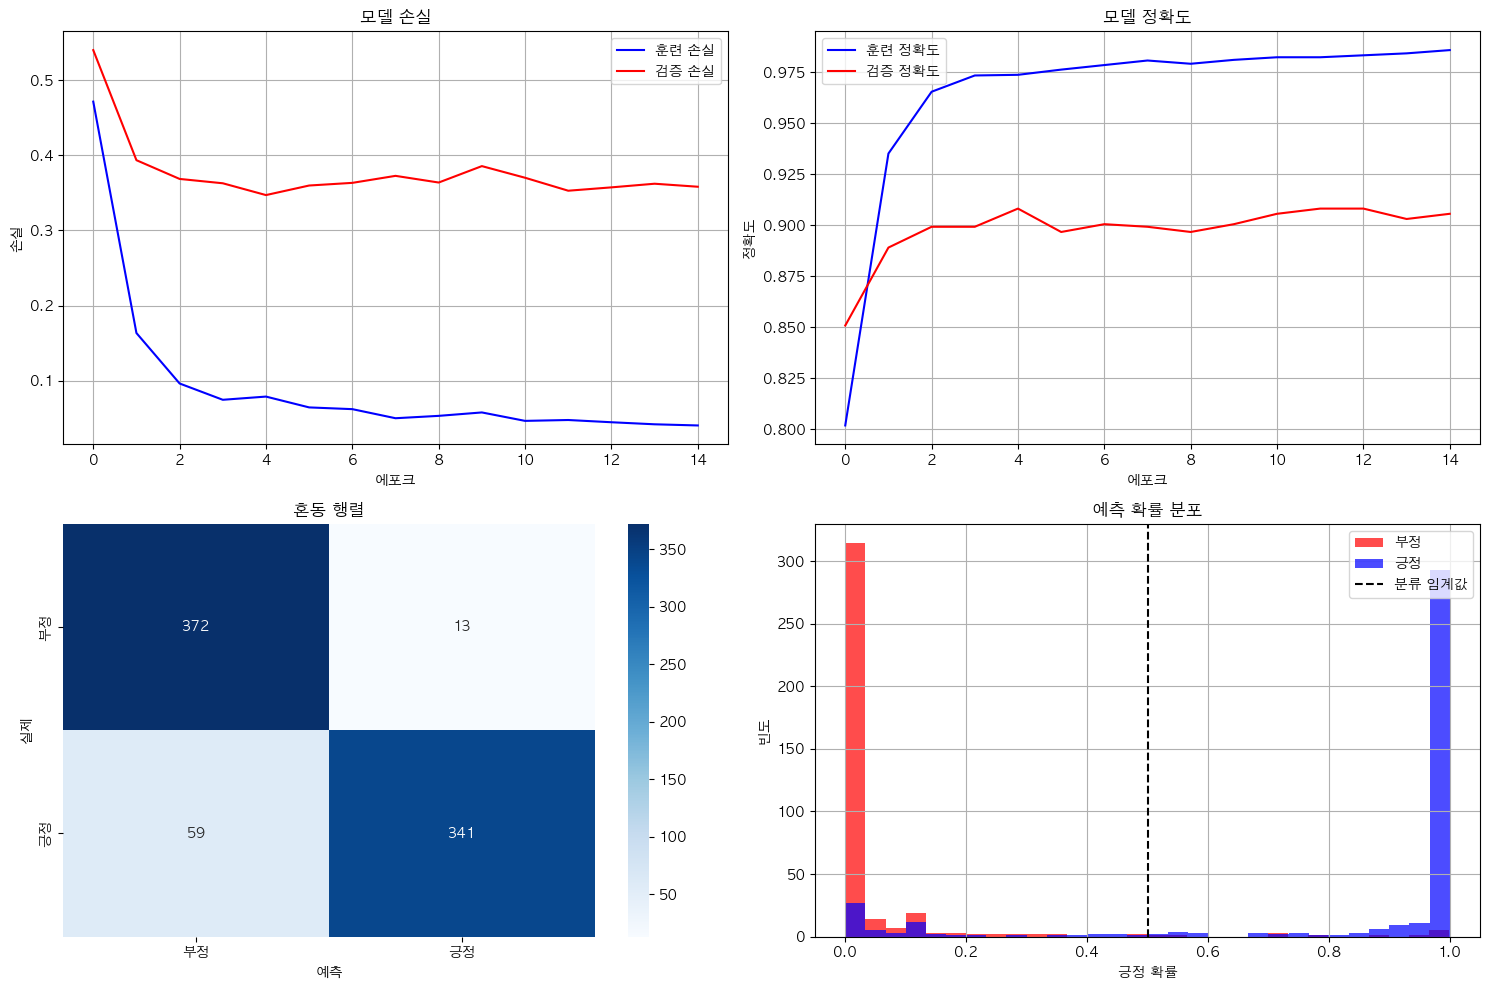

In [26]:
# Î™®Îç∏ ÏÑ±Îä• ÌèâÍ∞Ä Î∞è ÏãúÍ∞ÅÌôî
print("üìä Î™®Îç∏ ÏÑ±Îä• ÌèâÍ∞Ä!")
print("=" * 40)

if 'history' in locals() and 'model' in locals():
    
    # 1. ÏòàÏ∏° ÏàòÌñâ
    y_pred_prob = model.predict(X_test_scaled)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # 2. ÏÑ±Îä• ÏßÄÌëú Í≥ÑÏÇ∞
    accuracy = accuracy_score(y_test, y_pred)
    print(f"üéØ ÏµúÏ¢Ö ÌÖåÏä§Ìä∏ Ï†ïÌôïÎèÑ: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # 3. ÏÉÅÏÑ∏ Î∂ÑÎ•ò Î≥¥Í≥†ÏÑú
    print(f"\nüìã ÏÉÅÏÑ∏ Î∂ÑÎ•ò Î≥¥Í≥†ÏÑú:")
    print(classification_report(y_test, y_pred, target_names=['Î∂ÄÏ†ï', 'Í∏çÏ†ï']))
    
    # 4. ÌòºÎèô ÌñâÎ†¨
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nüîç ÌòºÎèô ÌñâÎ†¨:")
    print(f"Ïã§Ï†ú\\ÏòàÏ∏°   Î∂ÄÏ†ï    Í∏çÏ†ï")
    print(f"Î∂ÄÏ†ï      {cm[0,0]:4d}   {cm[0,1]:4d}")
    print(f"Í∏çÏ†ï      {cm[1,0]:4d}   {cm[1,1]:4d}")
    
    # 5. ÌõàÎ†® Í≥ºÏ†ï ÏãúÍ∞ÅÌôî
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # ÏÜêÏã§ Í∑∏ÎûòÌîÑ
    axes[0,0].plot(history.history['loss'], label='ÌõàÎ†® ÏÜêÏã§', color='blue')
    axes[0,0].plot(history.history['val_loss'], label='Í≤ÄÏ¶ù ÏÜêÏã§', color='red')
    axes[0,0].set_title('Î™®Îç∏ ÏÜêÏã§')
    axes[0,0].set_xlabel('ÏóêÌè¨ÌÅ¨')
    axes[0,0].set_ylabel('ÏÜêÏã§')
    axes[0,0].legend()
    axes[0,0].grid(True)
    
    # Ï†ïÌôïÎèÑ Í∑∏ÎûòÌîÑ
    axes[0,1].plot(history.history['accuracy'], label='ÌõàÎ†® Ï†ïÌôïÎèÑ', color='blue')
    axes[0,1].plot(history.history['val_accuracy'], label='Í≤ÄÏ¶ù Ï†ïÌôïÎèÑ', color='red')
    axes[0,1].set_title('Î™®Îç∏ Ï†ïÌôïÎèÑ')
    axes[0,1].set_xlabel('ÏóêÌè¨ÌÅ¨')
    axes[0,1].set_ylabel('Ï†ïÌôïÎèÑ')
    axes[0,1].legend()
    axes[0,1].grid(True)
    
    # ÌòºÎèô ÌñâÎ†¨ ÌûàÌä∏Îßµ
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Î∂ÄÏ†ï', 'Í∏çÏ†ï'], 
                yticklabels=['Î∂ÄÏ†ï', 'Í∏çÏ†ï'], ax=axes[1,0])
    axes[1,0].set_title('ÌòºÎèô ÌñâÎ†¨')
    axes[1,0].set_xlabel('ÏòàÏ∏°')
    axes[1,0].set_ylabel('Ïã§Ï†ú')
    
    # ÏòàÏ∏° ÌôïÎ•† Î∂ÑÌè¨
    axes[1,1].hist(y_pred_prob[y_test==0], bins=30, alpha=0.7, label='Î∂ÄÏ†ï', color='red')
    axes[1,1].hist(y_pred_prob[y_test==1], bins=30, alpha=0.7, label='Í∏çÏ†ï', color='blue')
    axes[1,1].axvline(x=0.5, color='black', linestyle='--', label='Î∂ÑÎ•ò ÏûÑÍ≥ÑÍ∞í')
    axes[1,1].set_title('ÏòàÏ∏° ÌôïÎ•† Î∂ÑÌè¨')
    axes[1,1].set_xlabel('Í∏çÏ†ï ÌôïÎ•†')
    axes[1,1].set_ylabel('ÎπàÎèÑ')
    axes[1,1].legend()
    axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("‚ùå ÌõàÎ†® Í∏∞Î°ùÏù¥ÎÇò Î™®Îç∏Ïù¥ ÏóÜÏùå")


In [27]:
# Î≥ÄÏàò ÏÉÅÌÉú ÌôïÏù∏ Î∞è ÎîîÎ≤ÑÍπÖ (ÏÉÅÏÑ∏ Î≤ÑÏ†Ñ)
print("üîç ÌòÑÏû¨ Î≥ÄÏàò ÏÉÅÌÉú ÏÉÅÏÑ∏ ÌôïÏù∏")
print("=" * 60)

# ÌïÑÏàò Î≥ÄÏàòÎì§ ÌôïÏù∏
required_vars = {
    'vectorizer': 'TF-IDF Î≤°ÌÑ∞ÎùºÏù¥Ï†Ä',
    'scaler': 'ÌäπÏÑ± Ï†ïÍ∑úÌôîÍ∏∞', 
    'model': 'ÌõàÎ†®Îêú MLP Î™®Îç∏',
    'history': 'ÌõàÎ†® ÌûàÏä§ÌÜ†Î¶¨',
    'X_train_scaled': 'ÌõàÎ†® ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞',
    'X_test_scaled': 'ÌÖåÏä§Ìä∏ ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞',
    'y_train': 'ÌõàÎ†® Î†àÏù¥Î∏î',
    'y_test': 'ÌÖåÏä§Ìä∏ Î†àÏù¥Î∏î'
}

print("üìã ÌïÑÏàò Î≥ÄÏàò Ï°¥Ïû¨ Ïó¨Î∂Ä:")
missing_vars = []
for var_name, description in required_vars.items():
    if var_name in locals():
        if var_name == 'model' and hasattr(locals()[var_name], 'summary'):
            print(f"‚úÖ {var_name}: {description} - Î™®Îç∏ Ï†ïÏùòÎê®")
        elif var_name in ['X_train_scaled', 'X_test_scaled'] and hasattr(locals()[var_name], 'shape'):
            print(f"‚úÖ {var_name}: {description} - ÌòïÌÉú: {locals()[var_name].shape}")
        elif var_name in ['y_train', 'y_test'] and hasattr(locals()[var_name], 'shape'):
            print(f"‚úÖ {var_name}: {description} - ÌòïÌÉú: {locals()[var_name].shape}")
        else:
            print(f"‚úÖ {var_name}: {description} - Ï†ïÏùòÎê®")
    else:
        print(f"‚ùå {var_name}: {description} - Ï†ïÏùòÎêòÏßÄ ÏïäÏùå")
        missing_vars.append(var_name)

if missing_vars:
    print(f"\n‚ö†Ô∏è ÎàÑÎùΩÎêú Î≥ÄÏàò: {', '.join(missing_vars)}")
    print("üí° Ìï¥Í≤∞ Î∞©Î≤ï:")
    if 'vectorizer' in missing_vars or 'scaler' in missing_vars:
        print("   1. Cell 12, 13ÏùÑ Îã§Ïãú Ïã§ÌñâÌïòÏó¨ Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ ÏôÑÎ£å")
    if 'model' in missing_vars:
        print("   2. Cell 15Î•º Îã§Ïãú Ïã§ÌñâÌïòÏó¨ Î™®Îç∏ ÏÉùÏÑ±")
    if 'history' in missing_vars:
        print("   3. Cell 16, 17ÏùÑ Îã§Ïãú Ïã§ÌñâÌïòÏó¨ Î™®Îç∏ ÌõàÎ†® ÏôÑÎ£å")
else:
    print("\nüéâ Î™®Îì† ÌïÑÏàò Î≥ÄÏàòÍ∞Ä Ï†ïÏùòÎêòÏñ¥ ÏûàÏäµÎãàÎã§!")
    
print(f"\nüî¢ ÌòÑÏû¨ Ï†ïÏùòÎêú Ï†ÑÏ≤¥ Î≥ÄÏàò Í∞úÏàò: {len([v for v in locals() if not v.startswith('_')])}")


üîç ÌòÑÏû¨ Î≥ÄÏàò ÏÉÅÌÉú ÏÉÅÏÑ∏ ÌôïÏù∏
üìã ÌïÑÏàò Î≥ÄÏàò Ï°¥Ïû¨ Ïó¨Î∂Ä:
‚úÖ vectorizer: TF-IDF Î≤°ÌÑ∞ÎùºÏù¥Ï†Ä - Ï†ïÏùòÎê®
‚úÖ scaler: ÌäπÏÑ± Ï†ïÍ∑úÌôîÍ∏∞ - Ï†ïÏùòÎê®
‚úÖ model: ÌõàÎ†®Îêú MLP Î™®Îç∏ - Î™®Îç∏ Ï†ïÏùòÎê®
‚úÖ history: ÌõàÎ†® ÌûàÏä§ÌÜ†Î¶¨ - Ï†ïÏùòÎê®
‚úÖ X_train_scaled: ÌõàÎ†® ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞ - ÌòïÌÉú: (3136, 5000)
‚úÖ X_test_scaled: ÌÖåÏä§Ìä∏ ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞ - ÌòïÌÉú: (785, 5000)
‚úÖ y_train: ÌõàÎ†® Î†àÏù¥Î∏î - ÌòïÌÉú: (3136,)
‚úÖ y_test: ÌÖåÏä§Ìä∏ Î†àÏù¥Î∏î - ÌòïÌÉú: (785,)

üéâ Î™®Îì† ÌïÑÏàò Î≥ÄÏàòÍ∞Ä Ï†ïÏùòÎêòÏñ¥ ÏûàÏäµÎãàÎã§!

üî¢ ÌòÑÏû¨ Ï†ïÏùòÎêú Ï†ÑÏ≤¥ Î≥ÄÏàò Í∞úÏàò: 83


In [28]:
# ÏÉàÎ°úÏö¥ ÎåìÍ∏Ä ÏòàÏ∏° Ìï®Ïàò
def predict_sentiment(text, vectorizer, scaler, model):
    """
    ÏÉàÎ°úÏö¥ ÎåìÍ∏ÄÏùò Í∑πÏÑ±ÏùÑ ÏòàÏ∏°ÌïòÎäî Ìï®Ïàò
    """
    # ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨
    processed_text = preprocess_text(text)
    
    # TF-IDF Î≤°ÌÑ∞Ìôî
    text_vector = vectorizer.transform([processed_text])
    
    # Ï†ïÍ∑úÌôî
    text_scaled = scaler.transform(text_vector.toarray())
    
    # ÏòàÏ∏°
    prob = model.predict(text_scaled)[0][0]
    prediction = "Í∏çÏ†ï" if prob > 0.5 else "Î∂ÄÏ†ï"
    confidence = prob if prob > 0.5 else (1 - prob)
    
    return prediction, confidence, prob

# ÏòàÏ∏° ÌÖåÏä§Ìä∏
print("üéØ ÏÉàÎ°úÏö¥ ÎåìÍ∏Ä ÏòàÏ∏° ÌÖåÏä§Ìä∏!")
print("=" * 50)

# ÌïÑÏöîÌïú Î≥ÄÏàòÎì§ ÌôïÏù∏ (globals() ÏÇ¨Ïö©ÏúºÎ°ú Î≥ÄÍ≤Ω)
required_prediction_vars = ['vectorizer', 'scaler', 'model']
missing_prediction_vars = []

print("üîç Î≥ÄÏàò Ï°¥Ïû¨ Ïó¨Î∂Ä ÏÉÅÏÑ∏ ÌôïÏù∏:")
for var in required_prediction_vars:
    if var in globals():
        print(f"‚úÖ {var}: globals()ÏóêÏÑú Î∞úÍ≤¨")
    elif var in locals():
        print(f"‚úÖ {var}: locals()ÏóêÏÑú Î∞úÍ≤¨")
    else:
        print(f"‚ùå {var}: Ï∞æÏùÑ Ïàò ÏóÜÏùå")
        missing_prediction_vars.append(var)
        
print(f"\nüìä ÎàÑÎùΩÎêú Î≥ÄÏàò: {missing_prediction_vars if missing_prediction_vars else 'ÏóÜÏùå'}")

# Î≥ÄÏàòÎì§ÏùÑ ÏïàÏ†ÑÌïòÍ≤å Í∞ÄÏ†∏Ïò§Í∏∞
try:
    # globals()ÏóêÏÑú Î≥ÄÏàò Í∞ÄÏ†∏Ïò§Í∏∞ ÏãúÎèÑ
    vec = globals().get('vectorizer', locals().get('vectorizer', None))
    sc = globals().get('scaler', locals().get('scaler', None))  
    mod = globals().get('model', locals().get('model', None))
    
    if vec is not None and sc is not None and mod is not None:
        print("‚úÖ Î™®Îì† Î≥ÄÏàòÎ•º ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Í∞ÄÏ†∏ÏôîÏäµÎãàÎã§!")
        
        test_comments = [
            "Ï†ïÎßê ÎßõÏûàÏñ¥Ïöî! ÏµúÍ≥†ÏûÖÎãàÎã§!",
            "ÏÑúÎπÑÏä§Í∞Ä Î≥ÑÎ°úÎÑ§Ïöî... Ïã§ÎßùÏù¥ÏóêÏöî",
            "Í∞ÄÍ≤© ÎåÄÎπÑ Í¥úÏ∞ÆÏùÄ Í≤É Í∞ôÏïÑÏöî",
            "ÏôÑÏ†Ñ ÏµúÏïÖÏù¥ÏóêÏöî. Îã§ÏãúÎäî Ïïà ÏôÄÏöî",
            "ÏßÅÏõêÎì§Ïù¥ ÏπúÏ†àÌïòÍ≥† ÏùåÏãùÎèÑ Ï¢ãÏïÑÏöî",
            "Í∑∏ÎÉ• Í∑∏ÎûòÏöî. Î≥¥ÌÜµ ÏàòÏ§Ä"
        ]
        
        print("\nüìù ÌÖåÏä§Ìä∏ ÎåìÍ∏ÄÎì§:")
        print("-" * 50)
        
        for i, comment in enumerate(test_comments, 1):
            try:
                pred, conf, prob = predict_sentiment(comment, vec, sc, mod)
                print(f"{i}. \"{comment}\"")
                print(f"   ‚Üí ÏòàÏ∏°: {pred} (Ïã†Î¢∞ÎèÑ: {conf:.3f}, ÌôïÎ•†: {prob:.3f})")
                print()
            except Exception as e:
                print(f"{i}. \"{comment}\"")
                print(f"   ‚Üí ÏòàÏ∏° Ïò§Î•ò: {e}")
                print()
            
        print("‚úÖ ÏòàÏ∏° ÌÖåÏä§Ìä∏ ÏôÑÎ£å!")
    else:
        print("‚ùå ÏùºÎ∂Ä Î≥ÄÏàòÎ•º Í∞ÄÏ†∏Ïò¨ Ïàò ÏóÜÏäµÎãàÎã§:")
        print(f"   - vectorizer: {'‚úÖ' if vec is not None else '‚ùå'}")
        print(f"   - scaler: {'‚úÖ' if sc is not None else '‚ùå'}")
        print(f"   - model: {'‚úÖ' if mod is not None else '‚ùå'}")
        missing_prediction_vars = [var for var, obj in [('vectorizer', vec), ('scaler', sc), ('model', mod)] if obj is None]
        
except Exception as e:
    print(f"‚ùå Î≥ÄÏàò Í∞ÄÏ†∏Ïò§Í∏∞ Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
    missing_prediction_vars = required_prediction_vars
    print("\nüîß Ìï¥Í≤∞ Î∞©Î≤ï:")
    print("1. Î®ºÏ†Ä ÏúÑÏùò 'Î≥ÄÏàò ÏÉÅÌÉú ÌôïÏù∏' ÏÖÄÏùÑ Ïã§ÌñâÌïòÏó¨ Ïñ¥Îñ§ Î≥ÄÏàòÍ∞Ä ÎàÑÎùΩÎêòÏóàÎäîÏßÄ ÌôïÏù∏")
    print("2. ÎàÑÎùΩÎêú Î≥ÄÏàòÏóê Îî∞Îùº Îã§Ïùå ÏÖÄÎì§ÏùÑ ÏàúÏÑúÎåÄÎ°ú Ïã§Ìñâ:")
    print("   - vectorizer, scaler ÎàÑÎùΩ: Cell 12, 13 (Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨)")
    print("   - model ÎàÑÎùΩ: Cell 15 (Î™®Îç∏ ÏÉùÏÑ±)")
    print("   - Î™®Îì† Î≥ÄÏàò ÎàÑÎùΩ: Cell 12Î∂ÄÌÑ∞ 17ÍπåÏßÄ ÏàúÏÑúÎåÄÎ°ú Ïã§Ìñâ")
    print("3. Î™®Îì† Î≥ÄÏàòÍ∞Ä Ï§ÄÎπÑÎêòÎ©¥ Ïù¥ ÏÖÄÏùÑ Îã§Ïãú Ïã§Ìñâ")


üéØ ÏÉàÎ°úÏö¥ ÎåìÍ∏Ä ÏòàÏ∏° ÌÖåÏä§Ìä∏!
üîç Î≥ÄÏàò Ï°¥Ïû¨ Ïó¨Î∂Ä ÏÉÅÏÑ∏ ÌôïÏù∏:
‚úÖ vectorizer: globals()ÏóêÏÑú Î∞úÍ≤¨
‚úÖ scaler: globals()ÏóêÏÑú Î∞úÍ≤¨
‚úÖ model: globals()ÏóêÏÑú Î∞úÍ≤¨

üìä ÎàÑÎùΩÎêú Î≥ÄÏàò: ÏóÜÏùå
‚úÖ Î™®Îì† Î≥ÄÏàòÎ•º ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Í∞ÄÏ†∏ÏôîÏäµÎãàÎã§!

üìù ÌÖåÏä§Ìä∏ ÎåìÍ∏ÄÎì§:
--------------------------------------------------
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 112ms/step
1. "Ï†ïÎßê ÎßõÏûàÏñ¥Ïöî! ÏµúÍ≥†ÏûÖÎãàÎã§!"
   ‚Üí ÏòàÏ∏°: Í∏çÏ†ï (Ïã†Î¢∞ÎèÑ: 0.998, ÌôïÎ•†: 0.998)

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 60ms/step
2. "ÏÑúÎπÑÏä§Í∞Ä Î≥ÑÎ°úÎÑ§Ïöî... Ïã§ÎßùÏù¥ÏóêÏöî"
   ‚Üí ÏòàÏ∏°: Î∂ÄÏ†ï (Ïã†Î¢∞ÎèÑ: 0.991, ÌôïÎ•†: 0.009)

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 82ms/step
3. "Í∞ÄÍ≤© ÎåÄÎπÑ Í¥úÏ∞ÆÏùÄ Í≤É Í∞ôÏïÑÏöî"
   ‚Üí ÏòàÏ∏°: Î∂ÄÏ†ï (Ïã†Î¢∞ÎèÑ: 0.867, ÌôïÎ•†: 0.133)

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 62ms/step
4. "ÏôÑÏ†Ñ ÏµúÏïÖÏù¥ÏóêÏö

### ÌïôÏäµÎêú Î™®Îç∏ Ï∂úÎ†•

In [35]:
# Î™®Îì† Î†àÏù¥Ïñ¥Ïùò Í∞ÄÏ§ëÏπò Ï†ïÎ≥¥
for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    if weights:  # Í∞ÄÏ§ëÏπòÍ∞Ä ÏûàÎäî Î†àÏù¥Ïñ¥Îßå
        print(f"\nÎ†àÏù¥Ïñ¥ {i} ({layer.name}):")
        for j, weight in enumerate(weights):
            weight_type = "Í∞ÄÏ§ëÏπò ÌñâÎ†¨" if j == 0 else "Ìé∏Ìñ• Î≤°ÌÑ∞"
            print(f"  {weight_type}: {weight.shape}")


print("layer 0:")
layer_0_weights = model.layers[0].get_weights()[0]
print(layer_0_weights)


Î†àÏù¥Ïñ¥ 0 (hidden_layer_1):
  Í∞ÄÏ§ëÏπò ÌñâÎ†¨: (5000, 512)
  Ìé∏Ìñ• Î≤°ÌÑ∞: (512,)

Î†àÏù¥Ïñ¥ 1 (batch_norm_1):
  Í∞ÄÏ§ëÏπò ÌñâÎ†¨: (512,)
  Ìé∏Ìñ• Î≤°ÌÑ∞: (512,)
  Ìé∏Ìñ• Î≤°ÌÑ∞: (512,)
  Ìé∏Ìñ• Î≤°ÌÑ∞: (512,)

Î†àÏù¥Ïñ¥ 3 (hidden_layer_2):
  Í∞ÄÏ§ëÏπò ÌñâÎ†¨: (512, 256)
  Ìé∏Ìñ• Î≤°ÌÑ∞: (256,)

Î†àÏù¥Ïñ¥ 4 (batch_norm_2):
  Í∞ÄÏ§ëÏπò ÌñâÎ†¨: (256,)
  Ìé∏Ìñ• Î≤°ÌÑ∞: (256,)
  Ìé∏Ìñ• Î≤°ÌÑ∞: (256,)
  Ìé∏Ìñ• Î≤°ÌÑ∞: (256,)

Î†àÏù¥Ïñ¥ 6 (output_layer):
  Í∞ÄÏ§ëÏπò ÌñâÎ†¨: (256, 1)
  Ìé∏Ìñ• Î≤°ÌÑ∞: (1,)
layer 0:
[[-0.00184074  0.00662824 -0.01528402 ...  0.00791086 -0.06253667
  -0.009366  ]
 [-0.01015106 -0.01731848 -0.01124575 ... -0.00719958 -0.01466656
   0.00937681]
 [ 0.02167877 -0.03980364 -0.01910255 ... -0.0134962   0.03559166
   0.03706517]
 ...
 [-0.02955687 -0.00075333  0.01456653 ...  0.01215863  0.02038457
   0.01842212]
 [ 0.03319123 -0.03712281 -0.01102464 ... -0.00251478  0.04739066
  -0.00584281]
 [ 0.02822752 -0.00695312  0.02278803 ... -0.03602394  0.03114434
  -0.0

In [29]:
# Î™®Îç∏ Î∞è Ï†ÑÏ≤òÎ¶¨Í∏∞ Ï†ÄÏû•
print("üíæ Î™®Îç∏ Î∞è Ï†ÑÏ≤òÎ¶¨Í∏∞ Ï†ÄÏû•!")
print("=" * 50)

import pickle
import os
from datetime import datetime

# Ï†ÄÏû•Ìï† ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±
save_dir = "saved_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"üìÅ Ï†ÄÏû• ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±: {save_dir}")

# ÌòÑÏû¨ ÏãúÍ∞ÑÏùÑ Ìè¨Ìï®Ìïú ÌååÏùºÎ™Ö ÏÉùÏÑ±
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"sentiment_mlp_model_{timestamp}"

try:
    # Î≥ÄÏàòÎì§ÏùÑ ÏïàÏ†ÑÌïòÍ≤å Í∞ÄÏ†∏Ïò§Í∏∞
    vec = globals().get('vectorizer', locals().get('vectorizer', None))
    sc = globals().get('scaler', locals().get('scaler', None))  
    mod = globals().get('model', locals().get('model', None))
    hist = globals().get('history', locals().get('history', None))
    
    if vec is not None and sc is not None and mod is not None:
        
        # 1. Keras Î™®Îç∏ Ï†ÄÏû• (.keras ÌòïÏãù - Í∂åÏû•)
        model_path = os.path.join(save_dir, f"{model_name}.keras")
        mod.save(model_path)
        print(f"‚úÖ Î™®Îç∏ Ï†ÄÏû• ÏôÑÎ£å: {model_path}")
        
        # 2. TF-IDF Vectorizer Ï†ÄÏû•
        vectorizer_path = os.path.join(save_dir, f"{model_name}_vectorizer.pkl")
        with open(vectorizer_path, 'wb') as f:
            pickle.dump(vec, f)
        print(f"‚úÖ TF-IDF Î≤°ÌÑ∞ÎùºÏù¥Ï†Ä Ï†ÄÏû• ÏôÑÎ£å: {vectorizer_path}")
        
        # 3. StandardScaler Ï†ÄÏû•
        scaler_path = os.path.join(save_dir, f"{model_name}_scaler.pkl")
        with open(scaler_path, 'wb') as f:
            pickle.dump(sc, f)
        print(f"‚úÖ ÌëúÏ§ÄÌôî Ïä§ÏºÄÏùºÎü¨ Ï†ÄÏû• ÏôÑÎ£å: {scaler_path}")
        
        # 4. ÌõàÎ†® ÌûàÏä§ÌÜ†Î¶¨ Ï†ÄÏû• (ÏûàÎã§Î©¥)
        if hist is not None:
            history_path = os.path.join(save_dir, f"{model_name}_history.pkl")
            with open(history_path, 'wb') as f:
                pickle.dump(hist.history, f)
            print(f"‚úÖ ÌõàÎ†® ÌûàÏä§ÌÜ†Î¶¨ Ï†ÄÏû• ÏôÑÎ£å: {history_path}")
        
        # 5. Î™®Îç∏ Ï†ïÎ≥¥ ÌÖçÏä§Ìä∏ ÌååÏùº Ï†ÄÏû•
        info_path = os.path.join(save_dir, f"{model_name}_info.txt")
        with open(info_path, 'w', encoding='utf-8') as f:
            f.write(f"Í∞êÏ†ï Î∂ÑÏÑù MLP Î™®Îç∏ Ï†ïÎ≥¥\\n")
            f.write(f"=" * 40 + "\\n")
            f.write(f"ÏÉùÏÑ± ÏãúÍ∞Ñ: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\\n")
            f.write(f"Î™®Îç∏ ÌååÏùº: {model_name}.keras\\n")
            f.write(f"Î≤°ÌÑ∞ÎùºÏù¥Ï†Ä: {model_name}_vectorizer.pkl\\n")
            f.write(f"Ïä§ÏºÄÏùºÎü¨: {model_name}_scaler.pkl\\n")
            
            # Î™®Îç∏ Íµ¨Ï°∞ Ï†ïÎ≥¥
            f.write(f"\\nÎ™®Îç∏ Íµ¨Ï°∞:\\n")
            mod.summary(print_fn=lambda x: f.write(x + '\\n'))
            
            # ÏÑ±Îä• Ï†ïÎ≥¥ (ÏûàÎã§Î©¥)
            if hist is not None:
                final_acc = hist.history['val_accuracy'][-1]
                final_loss = hist.history['val_loss'][-1]
                f.write(f"\\nÏµúÏ¢Ö ÏÑ±Îä•:\\n")
                f.write(f"Í≤ÄÏ¶ù Ï†ïÌôïÎèÑ: {final_acc:.4f}\\n")
                f.write(f"Í≤ÄÏ¶ù ÏÜêÏã§: {final_loss:.4f}\\n")
        
        print(f"‚úÖ Î™®Îç∏ Ï†ïÎ≥¥ Ï†ÄÏû• ÏôÑÎ£å: {info_path}")
        
        print(f"\\nüéâ Î™®Îì† ÌååÏùº Ï†ÄÏû• ÏôÑÎ£å!")
        print(f"üìÇ Ï†ÄÏû• ÏúÑÏπò: {os.path.abspath(save_dir)}")
        print(f"üìã Ï†ÄÏû•Îêú ÌååÏùºÎì§:")
        print(f"   - {model_name}.keras (Î™®Îç∏)")
        print(f"   - {model_name}_vectorizer.pkl (TF-IDF)")
        print(f"   - {model_name}_scaler.pkl (ÌëúÏ§ÄÌôî)")
        print(f"   - {model_name}_history.pkl (ÌõàÎ†®Í∏∞Î°ù)")
        print(f"   - {model_name}_info.txt (Î™®Îç∏Ï†ïÎ≥¥)")
        
        # Ï†ÑÏó≠ Î≥ÄÏàòÎ°ú Ï†ÄÏû• Í≤ΩÎ°úÎì§ Ï†ÄÏû• (ÎÇòÏ§ëÏóê ÏÇ¨Ïö©ÌïòÍ∏∞ ÏúÑÌï¥)
        globals()['saved_model_path'] = model_path
        globals()['saved_vectorizer_path'] = vectorizer_path
        globals()['saved_scaler_path'] = scaler_path
        globals()['model_name'] = model_name
        
    else:
        print("‚ùå ÌïÑÏöîÌïú Î≥ÄÏàòÎì§ÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§:")
        print(f"   - vectorizer: {'‚úÖ' if vec is not None else '‚ùå'}")
        print(f"   - scaler: {'‚úÖ' if sc is not None else '‚ùå'}")
        print(f"   - model: {'‚úÖ' if mod is not None else '‚ùå'}")
        print("\\nüí° Î®ºÏ†Ä Î™®Îç∏ ÌõàÎ†®ÏùÑ ÏôÑÎ£åÌï¥Ï£ºÏÑ∏Ïöî.")
        
except Exception as e:
    print(f"‚ùå Ï†ÄÏû• Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
    print("üí° Î™®Îç∏Í≥º Ï†ÑÏ≤òÎ¶¨Í∏∞Í∞Ä Ï†úÎåÄÎ°ú ÌõàÎ†®ÎêòÏóàÎäîÏßÄ ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî.")


üíæ Î™®Îç∏ Î∞è Ï†ÑÏ≤òÎ¶¨Í∏∞ Ï†ÄÏû•!
‚úÖ Î™®Îç∏ Ï†ÄÏû• ÏôÑÎ£å: saved_models/sentiment_mlp_model_20250919_191628.keras
‚úÖ TF-IDF Î≤°ÌÑ∞ÎùºÏù¥Ï†Ä Ï†ÄÏû• ÏôÑÎ£å: saved_models/sentiment_mlp_model_20250919_191628_vectorizer.pkl
‚úÖ ÌëúÏ§ÄÌôî Ïä§ÏºÄÏùºÎü¨ Ï†ÄÏû• ÏôÑÎ£å: saved_models/sentiment_mlp_model_20250919_191628_scaler.pkl
‚úÖ ÌõàÎ†® ÌûàÏä§ÌÜ†Î¶¨ Ï†ÄÏû• ÏôÑÎ£å: saved_models/sentiment_mlp_model_20250919_191628_history.pkl


‚úÖ Î™®Îç∏ Ï†ïÎ≥¥ Ï†ÄÏû• ÏôÑÎ£å: saved_models/sentiment_mlp_model_20250919_191628_info.txt
\nüéâ Î™®Îì† ÌååÏùº Ï†ÄÏû• ÏôÑÎ£å!
üìÇ Ï†ÄÏû• ÏúÑÏπò: /Users/aaron/Github/Kmong/Aaron/hg-mldl2/003-ann-basic/saved_models
üìã Ï†ÄÏû•Îêú ÌååÏùºÎì§:
   - sentiment_mlp_model_20250919_191628.keras (Î™®Îç∏)
   - sentiment_mlp_model_20250919_191628_vectorizer.pkl (TF-IDF)
   - sentiment_mlp_model_20250919_191628_scaler.pkl (ÌëúÏ§ÄÌôî)
   - sentiment_mlp_model_20250919_191628_history.pkl (ÌõàÎ†®Í∏∞Î°ù)
   - sentiment_mlp_model_20250919_191628_info.txt (Î™®Îç∏Ï†ïÎ≥¥)


In [53]:
# Ï†ÄÏû•Îêú Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞ Î∞è Ï∂îÎ°† Ìï®Ïàò
print("üîÑ Ï†ÄÏû•Îêú Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞ Î∞è Ï∂îÎ°† Ìï®Ïàò ÏÉùÏÑ±!")
print("=" * 60)

from tensorflow.keras.models import load_model
import pickle
import re

class SentimentPredictor:
    """Í∞êÏ†ï Î∂ÑÏÑù ÏòàÏ∏°Í∏∞ ÌÅ¥ÎûòÏä§"""
    
    def __init__(self, model_path, vectorizer_path, scaler_path):
        """
        Ï†ÄÏû•Îêú Î™®Îç∏Í≥º Ï†ÑÏ≤òÎ¶¨Í∏∞Îì§ÏùÑ Î∂àÎü¨ÏôÄÏÑú Ï¥àÍ∏∞Ìôî
        
        Args:
            model_path: Ï†ÄÏû•Îêú Keras Î™®Îç∏ Í≤ΩÎ°ú
            vectorizer_path: Ï†ÄÏû•Îêú TF-IDF Î≤°ÌÑ∞ÎùºÏù¥Ï†Ä Í≤ΩÎ°ú  
            scaler_path: Ï†ÄÏû•Îêú StandardScaler Í≤ΩÎ°ú
        """
        self.model_path = model_path
        self.vectorizer_path = vectorizer_path
        self.scaler_path = scaler_path
        
        # Î™®Îç∏Í≥º Ï†ÑÏ≤òÎ¶¨Í∏∞ Î∂àÎü¨Ïò§Í∏∞
        self.load_components()
    
    def load_components(self):
        """Î™®Îç∏Í≥º Ï†ÑÏ≤òÎ¶¨Í∏∞Îì§ÏùÑ Î©îÎ™®Î¶¨Ïóê Î°úÎìú"""
        try:
            print("üì• Î™®Îç∏ Î∞è Ï†ÑÏ≤òÎ¶¨Í∏∞ Î°úÎî© Ï§ë...")
            
            # Keras Î™®Îç∏ Î°úÎìú
            self.model = load_model(self.model_path)
            print(f"‚úÖ Î™®Îç∏ Î°úÎìú ÏôÑÎ£å: {self.model_path}")
            
            # TF-IDF Î≤°ÌÑ∞ÎùºÏù¥Ï†Ä Î°úÎìú
            with open(self.vectorizer_path, 'rb') as f:
                self.vectorizer = pickle.load(f)
            print(f"‚úÖ TF-IDF Î≤°ÌÑ∞ÎùºÏù¥Ï†Ä Î°úÎìú ÏôÑÎ£å: {self.vectorizer_path}")
            
            # StandardScaler Î°úÎìú
            with open(self.scaler_path, 'rb') as f:
                self.scaler = pickle.load(f)
            print(f"‚úÖ ÌëúÏ§ÄÌôî Ïä§ÏºÄÏùºÎü¨ Î°úÎìú ÏôÑÎ£å: {self.scaler_path}")
            
            print("üéâ Î™®Îì† Ïª¥Ìè¨ÎÑåÌä∏ Î°úÎìú ÏôÑÎ£å!")
            
        except Exception as e:
            print(f"‚ùå Î°úÎî© Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
            raise
    
    def preprocess_text(self, text):
        """
        ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨ (ÌõàÎ†® ÏãúÏôÄ ÎèôÏùºÌïú Î∞©Ïãù)
        """
        if pd.isna(text):
            return ""
        
        # Î¨∏ÏûêÏó¥Î°ú Î≥ÄÌôò
        text = str(text)
        
        # HTML ÌÉúÍ∑∏ Ï†úÍ±∞
        text = re.sub(r'<[^>]+>', '', text)
        
        # URL Ï†úÍ±∞
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
        
        # Ïù¥Î©îÏùº Ï†úÍ±∞
        text = re.sub(r'\\S+@\\S+', '', text)
        
        # ÌäπÏàòÎ¨∏ÏûêÎäî Í≥µÎ∞±ÏúºÎ°ú ÎåÄÏ≤¥ (ÌïúÍ∏Ä, ÏòÅÎ¨∏, Ïà´ÏûêÎßå Ïú†ÏßÄ)
        text = re.sub(r'[^Í∞Ä-Ìû£a-zA-Z0-9\\s]', ' ', text)
        
        # Ïó∞ÏÜçÎêú Í≥µÎ∞±ÏùÑ ÌïòÎÇòÎ°ú
        text = re.sub(r'\\s+', ' ', text)
        
        # ÏïûÎí§ Í≥µÎ∞± Ï†úÍ±∞
        text = text.strip()
        
        return text
    
    def predict(self, text):
        """
        ÌÖçÏä§Ìä∏Ïùò Í∞êÏ†ïÏùÑ ÏòàÏ∏°
        
        Args:
            text: ÏòàÏ∏°Ìï† ÌÖçÏä§Ìä∏
            
        Returns:
            tuple: (ÏòàÏ∏°Í≤∞Í≥º, Ïã†Î¢∞ÎèÑ, ÏõêÏãúÌôïÎ•†)
        """
        try:
            # ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨
            processed_text = self.preprocess_text(text)
            
            # TF-IDF Î≤°ÌÑ∞Ìôî
            text_vector = self.vectorizer.transform([processed_text])
            
            # Ï†ïÍ∑úÌôî
            text_scaled = self.scaler.transform(text_vector.toarray())
            
            # ÏòàÏ∏°
            prob = self.model.predict(text_scaled, verbose=0)[0][0]
            prediction = "Í∏çÏ†ï" if prob > 0.5 else "Î∂ÄÏ†ï"
            confidence = prob if prob > 0.5 else (1 - prob)
            
            return prediction, confidence, prob
            
        except Exception as e:
            print(f"‚ùå ÏòàÏ∏° Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
            return "Ïò§Î•ò", 0.0, 0.0
    
    def predict_batch(self, texts):
        """
        Ïó¨Îü¨ ÌÖçÏä§Ìä∏Î•º ÌïúÎ≤àÏóê ÏòàÏ∏°
        
        Args:
            texts: ÏòàÏ∏°Ìï† ÌÖçÏä§Ìä∏ Î¶¨Ïä§Ìä∏
            
        Returns:
            list: [(ÏòàÏ∏°Í≤∞Í≥º, Ïã†Î¢∞ÎèÑ, ÏõêÏãúÌôïÎ•†), ...] ÌòïÌÉúÏùò Î¶¨Ïä§Ìä∏
        """
        results = []
        for text in texts:
            result = self.predict(text)
            results.append(result)
        return results
    
    def get_model_info(self):
        """Î™®Îç∏ Ï†ïÎ≥¥ Ï∂úÎ†•"""
        print("üìä Î™®Îç∏ Ï†ïÎ≥¥:")
        print(f"   - Î™®Îç∏ ÌååÏùº: {os.path.basename(self.model_path)}")
        print(f"   - Î≤°ÌÑ∞ÎùºÏù¥Ï†Ä: {os.path.basename(self.vectorizer_path)}")
        print(f"   - Ïä§ÏºÄÏùºÎü¨: {os.path.basename(self.scaler_path)}")
        
        # Î™®Îç∏ Íµ¨Ï°∞ Í∞ÑÎã® Ï†ïÎ≥¥
        total_params = self.model.count_params()
        print(f"   - Ï¥ù ÌååÎùºÎØ∏ÌÑ∞ Ïàò: {total_params:,}")

print("‚úÖ SentimentPredictor ÌÅ¥ÎûòÏä§ Ï†ïÏùò ÏôÑÎ£å!")
print("üí° ÏÇ¨Ïö©Î≤ï: predictor = SentimentPredictor(model_path, vectorizer_path, scaler_path)")


üîÑ Ï†ÄÏû•Îêú Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞ Î∞è Ï∂îÎ°† Ìï®Ïàò ÏÉùÏÑ±!
‚úÖ SentimentPredictor ÌÅ¥ÎûòÏä§ Ï†ïÏùò ÏôÑÎ£å!
üí° ÏÇ¨Ïö©Î≤ï: predictor = SentimentPredictor(model_path, vectorizer_path, scaler_path)


In [54]:
# Ï†ÄÏû•Îêú Î™®Îç∏Î°ú Ï∂îÎ°† ÌÖåÏä§Ìä∏
print("üß™ Ï†ÄÏû•Îêú Î™®Îç∏ Ï∂îÎ°† ÌÖåÏä§Ìä∏!")
print("=" * 50)

try:
    # Ï†ÄÏû•Îêú Í≤ΩÎ°úÎì§ Í∞ÄÏ†∏Ïò§Í∏∞
    model_path = globals().get('saved_model_path')
    vectorizer_path = globals().get('saved_vectorizer_path') 
    scaler_path = globals().get('saved_scaler_path')
    
    if model_path and vectorizer_path and scaler_path:
        print("üìÇ Ï†ÄÏû•Îêú Î™®Îç∏ Í≤ΩÎ°ú:")
        print(f"   - Î™®Îç∏: {os.path.basename(model_path)}")
        print(f"   - Î≤°ÌÑ∞ÎùºÏù¥Ï†Ä: {os.path.basename(vectorizer_path)}")
        print(f"   - Ïä§ÏºÄÏùºÎü¨: {os.path.basename(scaler_path)}")
        print()
        
        # SentimentPredictor Ïù∏Ïä§ÌÑ¥Ïä§ ÏÉùÏÑ±
        predictor = SentimentPredictor(model_path, vectorizer_path, scaler_path)
        
        print()
        # Î™®Îç∏ Ï†ïÎ≥¥ Ï∂úÎ†•
        predictor.get_model_info()
        
        print(f"\\nüéØ Ï∂îÎ°† ÌÖåÏä§Ìä∏ ÏãúÏûë!")
        print("-" * 50)
        
        # ÌÖåÏä§Ìä∏ ÎåìÍ∏ÄÎì§
        test_comments = [
            "Ï†ïÎßê ÎßõÏûàÏñ¥Ïöî! ÏµúÍ≥†ÏûÖÎãàÎã§!",
            "ÏÑúÎπÑÏä§Í∞Ä Î≥ÑÎ°úÎÑ§Ïöî... Ïã§ÎßùÏù¥ÏóêÏöî", 
            "Í∞ÄÍ≤© ÎåÄÎπÑ Í¥úÏ∞ÆÏùÄ Í≤É Í∞ôÏïÑÏöî",
            "ÏôÑÏ†Ñ ÏµúÏïÖÏù¥ÏóêÏöî. Îã§ÏãúÎäî Ïïà ÏôÄÏöî",
            "ÏßÅÏõêÎì§Ïù¥ ÏπúÏ†àÌïòÍ≥† ÏùåÏãùÎèÑ Ï¢ãÏïÑÏöî",
            "Í∑∏ÎÉ• Í∑∏ÎûòÏöî. Î≥¥ÌÜµ ÏàòÏ§Ä",
            "Îπ†Î•∏ Î∞∞ÏÜ° Í∞êÏÇ¨Ìï©ÎãàÎã§! Îòê Ï£ºÎ¨∏Ìï†Í≤åÏöî",
            "ÌíàÏßàÏù¥ ÎÑàÎ¨¥ Îñ®Ïñ¥Ï†∏Ïöî. ÌôòÎ∂à ÏõêÌï©ÎãàÎã§",
            "Í∏∞ÎåÄÌñàÎçò Í≤ÉÎ≥¥Îã§ Í¥úÏ∞ÆÎÑ§Ïöî",
            "Îèà ÏïÑÍπåÏõåÏöî. Ï∂îÏ≤úÌïòÏßÄ ÏïäÏäµÎãàÎã§"
        ]
        
        # Í∞úÎ≥Ñ ÏòàÏ∏° ÌÖåÏä§Ìä∏
        print("üìù Í∞úÎ≥Ñ ÏòàÏ∏° Í≤∞Í≥º:")
        for i, comment in enumerate(test_comments, 1):
            pred, conf, prob = predictor.predict(comment)
            print(f"{i:2d}. \\\"{comment}\\\"")
            print(f"    ‚Üí ÏòàÏ∏°: {pred} (Ïã†Î¢∞ÎèÑ: {conf:.3f}, ÌôïÎ•†: {prob:.3f})")
            print()
        
        # Î∞∞Ïπò ÏòàÏ∏° ÌÖåÏä§Ìä∏
        print("üîÑ Î∞∞Ïπò ÏòàÏ∏° ÌÖåÏä§Ìä∏:")
        batch_results = predictor.predict_batch(test_comments[:5])
        
        for i, (comment, (pred, conf, prob)) in enumerate(zip(test_comments[:5], batch_results), 1):
            print(f"{i}. {pred} ({conf:.3f}) - \\\"{comment[:30]}...\\\"")
        
        print(f"\\n‚úÖ Ï†ÄÏû•Îêú Î™®Îç∏ Ï∂îÎ°† ÌÖåÏä§Ìä∏ ÏôÑÎ£å!")
        print("üéâ Î™®Îç∏Ïù¥ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Ï†ÄÏû•ÎêòÍ≥† Î°úÎìúÎêòÏñ¥ Ï∂îÎ°†Ïù¥ Ï†ïÏÉÅ ÏûëÎèôÌï©ÎãàÎã§!")
        
        # Ï†ÑÏó≠ Î≥ÄÏàòÎ°ú predictor Ï†ÄÏû• (ÎÇòÏ§ëÏóê ÏÇ¨Ïö©ÌïòÍ∏∞ ÏúÑÌï¥)
        globals()['sentiment_predictor'] = predictor
        
    else:
        print("‚ùå Ï†ÄÏû•Îêú Î™®Îç∏ Í≤ΩÎ°úÎ•º Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")
        print("üí° Î®ºÏ†Ä Î™®Îç∏ Ï†ÄÏû• ÏÖÄÏùÑ Ïã§ÌñâÌï¥Ï£ºÏÑ∏Ïöî.")
        
        # ÏàòÎèôÏúºÎ°ú Í≤ΩÎ°ú ÏßÄÏ†ïÌïòÏó¨ ÌÖåÏä§Ìä∏ÌïòÎäî Î∞©Î≤ï ÏïàÎÇ¥
        print("\\nüîß ÏàòÎèô ÌÖåÏä§Ìä∏ Î∞©Î≤ï:")
        print("saved_models ÎîîÎ†âÌÜ†Î¶¨ÏóêÏÑú ÏµúÏã† Î™®Îç∏ ÌååÏùºÎì§ÏùÑ Ï∞æÏïÑÏÑú:")
        print("predictor = SentimentPredictor('Î™®Îç∏Í≤ΩÎ°ú.keras', 'Î≤°ÌÑ∞ÎùºÏù¥Ï†ÄÍ≤ΩÎ°ú.pkl', 'Ïä§ÏºÄÏùºÎü¨Í≤ΩÎ°ú.pkl')")
        
except Exception as e:
    print(f"‚ùå ÌÖåÏä§Ìä∏ Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
    import traceback
    traceback.print_exc()


üß™ Ï†ÄÏû•Îêú Î™®Îç∏ Ï∂îÎ°† ÌÖåÏä§Ìä∏!
üìÇ Ï†ÄÏû•Îêú Î™®Îç∏ Í≤ΩÎ°ú:
   - Î™®Îç∏: sentiment_mlp_model_20250916_193146.keras
   - Î≤°ÌÑ∞ÎùºÏù¥Ï†Ä: sentiment_mlp_model_20250916_193146_vectorizer.pkl
   - Ïä§ÏºÄÏùºÎü¨: sentiment_mlp_model_20250916_193146_scaler.pkl

üì• Î™®Îç∏ Î∞è Ï†ÑÏ≤òÎ¶¨Í∏∞ Î°úÎî© Ï§ë...
‚úÖ Î™®Îç∏ Î°úÎìú ÏôÑÎ£å: saved_models/sentiment_mlp_model_20250916_193146.keras
‚úÖ TF-IDF Î≤°ÌÑ∞ÎùºÏù¥Ï†Ä Î°úÎìú ÏôÑÎ£å: saved_models/sentiment_mlp_model_20250916_193146_vectorizer.pkl
‚úÖ ÌëúÏ§ÄÌôî Ïä§ÏºÄÏùºÎü¨ Î°úÎìú ÏôÑÎ£å: saved_models/sentiment_mlp_model_20250916_193146_scaler.pkl
üéâ Î™®Îì† Ïª¥Ìè¨ÎÑåÌä∏ Î°úÎìú ÏôÑÎ£å!

üìä Î™®Îç∏ Ï†ïÎ≥¥:
   - Î™®Îç∏ ÌååÏùº: sentiment_mlp_model_20250916_193146.keras
   - Î≤°ÌÑ∞ÎùºÏù¥Ï†Ä: sentiment_mlp_model_20250916_193146_vectorizer.pkl
   - Ïä§ÏºÄÏùºÎü¨: sentiment_mlp_model_20250916_193146_scaler.pkl
   - Ï¥ù ÌååÎùºÎØ∏ÌÑ∞ Ïàò: 2,695,169
\nüéØ Ï∂îÎ°† ÌÖåÏä§Ìä∏ ÏãúÏûë!
--------------------------------------------------
üìù Í∞úÎ≥Ñ ÏòàÏ∏° Í≤